In [1]:
import warnings
warnings.filterwarnings('ignore')


# Summary

1. [Load CSV and fast EDA](#begin)
2. [Outliers removal](#outliers)
3. [Retrieve and remove a random row from the clean dataset](#remove_row)
4. [Correlation analysis on clean dataset](#correlation_analysis)
5. [Transform columns and handling data (removing null values, normalization, ...)](#handling_data)
6. [Feature selection](#feature_selection)
7. [Principal Component Analysis (PCA)](#pca)
8. [Fast EDA V2](#fast_eda)
9. [Handling Imbalanced data](#imbalanced_data)
10. [Creating and evaluating classifiers performance](#creating_classifiers)
11. [Transform an original single row and predict the result](#predict_row)
12. [Conclusion](#conclusion)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import csr_matrix, issparse


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from fasteda import fast_eda

In [3]:


def read_tsv(path_file):
    """
    Reads a csv file and returns a DataFrame.
    """
    df = pd.read_csv(path_file, sep=",")  # Assuming ',' as the delimiter since the file is named .csv
    return df

def correlation_analysis(df):
    """
    Displays a correlation heatmap for the numerical features of the DataFrame.
    """
    # Calculating correlation matrix for the numerical features
    correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
    
    # Plotting the heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()
    

def remove_outliers(df):
    """
    Removes outliers using the IQR method for the numerical features of the DataFrame.
    Returns a DataFrame without outliers.
    """
    df_clean = df.copy()
    
    for column in df_clean.select_dtypes(include=['float64', 'int64']):
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtering out the outliers
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
        
    return df_clean


def side_by_side_correlation_analysis(df1, df2):
    """
    Displays side by side correlation heatmaps for the two provided DataFrames.
    """
    # Create a figure with two subplots (axes) side by side
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(28, 10))
    
    # Calculating correlation matrix for the first dataframe and plotting it
    correlation_matrix1 = df1.select_dtypes(include=['float64', 'int64']).corr()
    sns.heatmap(correlation_matrix1, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax1)
    ax1.set_title("Correlation Heatmap for df1")
    
    # Calculating correlation matrix for the second dataframe and plotting it
    correlation_matrix2 = df2.select_dtypes(include=['float64', 'int64']).corr()
    sns.heatmap(correlation_matrix2, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax2)
    ax2.set_title("Correlation Heatmap for df2")
    
    plt.tight_layout()
    plt.show()
    
    
def columns_transformer(df_work, target_column='resultado'):
    """
    Preprocesses the numerical data (imputation and scaling) and the categorical data (imputation and one-hot encoding).
    Does not apply transformations to the target column.
    Returns a processed DataFrame.
    """
    df = df_work.copy()
    
    # Separate target before processing
    target_data = df[target_column]
    
    # Drop target column from data
    df = df.drop(columns=[target_column])
    
    # Identify numeric columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Identify categorical columns
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # Create transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine transformers into a preprocessor step
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Applying the column transformation
    df_processed_array = preprocessor.fit_transform(df)
    
    # Getting feature names after one-hot encoding for creating a dataframe
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + cat_feature_names.tolist()
    
    # Convert array back to dataframe
    # Check if the matrix is sparse
    if issparse(df_processed_array):
        dense_array = df_processed_array.toarray()
    else:
        dense_array = df_processed_array
    
    df_processed = pd.DataFrame(dense_array, columns=all_feature_names)
        
    # Adding the target column back
    df_processed[target_column] = target_data.values
    
    df_processed[target_column].replace(['nao', 'sim'],[0, 1], inplace=True)
    
    return df_processed


def get_important_columns(df_processed):
    """
    Determines and visualizes the importance of features in the provided DataFrame using mutual information.
    
    Parameters:
    - df_processed (DataFrame): The input DataFrame with features and the target variable 'resultado'.
    
    Returns:
    - cols (list): List of important features based on a mutual information threshold.
    """
    
    # Separate features and target variable
    X = df_processed.drop(columns = 'resultado')
    y = df_processed.resultado
    
    # Calculate mutual information between each feature and the target variable
    mutual_info = mutual_info_regression(X, y)
    
    # Convert the mutual information values into a pandas Series for easy indexing
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X.columns
    
    # Sort the mutual information values in descending order
    sorted_mutual_info = mutual_info.sort_values(ascending=False)

    # Plot the mutual information values using a horizontal bar chart
    plt.figure(figsize=(15, 10))
    sorted_mutual_info.plot(kind='barh', color='skyblue')
    plt.title('Importância mútua das características')
    plt.xlabel('Importância mútua')
    plt.ylabel('Características')
    plt.gca().invert_yaxis()  # Ensure that the feature with the highest importance is at the top
    plt.show()
    
    # Filter out features that have mutual information greater than a specified threshold (0.005 in this case)
    cols = mutual_info[mutual_info > 0.005].index.tolist()
    
    return cols


def PCA_analysis(df_processed, target_column='resultado'):
    """
    Performs PCA on the processed DataFrame.
    Returns the cumulative explained variance and the number of components required to explain at least 95% of the variance.
    """    
    df_without_target = df_processed.drop(columns=[target_column])
    pca = PCA().fit(df_without_target)
    cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Number of components required to explain at least 90% of the variance
    n_components_90 = np.where(cumulative_explained_variance >= 0.90)[0][0] + 1
    
    # Plotting the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker='o')
    plt.axhline(y=0.90, color='r', linestyle='--')
    plt.axvline(x=n_components_90, color='r', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    plt.show()
    
    return cumulative_explained_variance, n_components_90



def undersample_dataframe(df, majority_class, minority_class, target_column):
    """
    Perform undersampling to balance the classes in the dataframe.
    
    Parameters:
    - df: The input dataframe.
    - minority_class: The minority class.
    - majority_class: The majority class.
    - target_column: The name of the target column which has values 0 or 1.
    
    Returns:
    - A balanced dataframe after undersampling.
    """
    
    # Split the dataframe into majority and minority classes
    df_majority = df[df[target_column] == majority_class]
    df_minority = df[df[target_column] == minority_class]
    
    # Determine the number of samples in the minority class
    minority_count = len(df_minority)
    
    # Randomly sample the majority class to match the number of samples in the minority class
    df_majority_undersampled = df_majority.sample(n=minority_count, random_state=42)
    
    # Concatenate the undersampled majority class with the minority class
    df_balanced = pd.concat([df_majority_undersampled, df_minority])
    
    # Shuffle the resulting dataframe to ensure a mix of the classes
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_balanced


def generate_principal_components(df, n,  target_column='resultado'):
    """
    Generates a DataFrame with the 'n' principal components of the given DataFrame 'df'.
    
    Parameters:
    - df: Input DataFrame.
    - n: Number of principal components to return.
    - column_target: name of target 
    
    Returns:
    - DataFrame containing the 'n' principal components.
    """
    
    # Extracting the specified column from df
    column_to_merge = df[[target_column]]
    
    df_without_target = df.drop(columns=[target_column])

    # Applying PCA
    pca = PCA(n_components=n)
    principal_components = pca.fit_transform(df_without_target)
    
    # Creating a DataFrame for the principal components
    columns = [f'PC{i+1}' for i in range(n)]
    df_principal_components = pd.DataFrame(data=principal_components, columns=columns)
    
    
    # Merging the specified column with df based on the index
    df_principal_components = df_principal_components.join(column_to_merge)

    return pca, df_principal_components


def splitTrainTest(data, target_column='resultado', test_size=0.3, random_state=None):
    """
    Splits the data into training and test sets, keeping the dataframes intact.
    
    Parameters:
    - data: DataFrame containing the data.
    - target_column: Name of the column to be used as the target variable. Default is 'resultado_nao'.
    - test_size: Proportion of the data to be used as test set. Default is 0.3.
    - random_state: Seed used by the random number generator. Default is None.
    
    Returns:
    - df_train, df_test, y_train, y_test: Training and test dataframes and target variables.
    """
    df_train, df_test = train_test_split(data, test_size=test_size, random_state=random_state)
    
    y_train = df_train[target_column]
    y_test = df_test[target_column]
    
    return df_train, df_test, y_train, y_test

# Function of rows:

In [4]:
def is_outlier(row, df):
    """
    Checks if the given row is an outlier in the original DataFrame using the IQR method for numerical features.
    
    Parameters:
    - row: The row to check (Pandas Series or one-row DataFrame).
    - df: The original DataFrame.
    
    Returns:
    - True if the row is an outlier, False otherwise.
    """
    # Convert the row to a Series if it's a one-row DataFrame
    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]

    # Check each numerical column
    for column in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Check if the value in the row for this column is outside the bounds
        if row[column] < lower_bound or row[column] > upper_bound:
            return True

    # If no outlier found in any column, return False
    return False


def transform_single_row_with_dataframe(row, df, pca, target_column='resultado'):
    """
    Transforms a single row by appending it to the original DataFrame, applying the columns_transformer,
    and returning the transformed row.

    Parameters:
    - row: A single row (Pandas Series or one-row DataFrame) from the original data.
    - df: The original DataFrame.
    - target_column: The target column name.

    Returns:
    - Transformed row as a DataFrame.
    """
    
    outlier = is_outlier(row, df)
                         
    if(not outlier):
        # Append the row to the original DataFrame
        combined_df = df.append(row, ignore_index=True)
        
        # Apply the columns_transformer to the combined DataFrame
        transformed_df = columns_transformer(combined_df, target_column=target_column)
        
        df_without_resultado = transformed_df.drop(columns=['resultado'])
            
        transformed_df_with_PCA = pca.fit_transform(df_without_resultado)
        # Creating a DataFrame for the principal components
        columns = [f'PC{i+1}' for i in range(transformed_df_with_PCA.shape[1])]
        df_principal_components = pd.DataFrame(data=transformed_df_with_PCA, columns=columns)
    
        # Extracting the specified column from v2
        column_to_merge = df[[target_column]]

        # Merging the specified column with df based on the index
        transformed_df_with_PCA = df_principal_components.join(column_to_merge)

        # Get the transformed row (last row in the transformed DataFrame)
        transformed_row = transformed_df_with_PCA.iloc[-1:]
        
        transformed_row[target_column].replace(['nao', 'sim'],[0, 1], inplace=True)
    else:
        print("outlier")
        return None
    return transformed_row

## Functions of Models of Machine Learning

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

def compare_models(final_df, target_column='resultado'):
    """
    Train various classifiers on the provided dataset, visualize their ROC curves,
    and return the classifier with the highest AUC.
    
    Parameters:
    - final_df (DataFrame): The input DataFrame containing features and the target variable.
    - target_column (str, optional): Name of the target variable column. Default is 'resultado'.
    
    Returns:
    - best_clf (classifier object): The classifier with the highest AUC.
    """
    
    df = final_df.copy()
    
    # Separate the dataset into features and the target variable
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split the data into 70% training and 30% testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define a list of classifiers to be evaluated
    classifiers = [
        ('Logistic Regression', LogisticRegression(max_iter=10000, random_state=42)),
        ('Random Forest', RandomForestClassifier(random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
        ('SVM', SVC(kernel='linear', probability=True, random_state=42))
    ]

    # Dictionary to store the ROC curve metrics for each classifier
    roc_values = {}

    # Train each classifier, make predictions, and compute ROC metrics
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_values[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}

    # Plot the ROC curves for all classifiers
    plt.figure(figsize=(10, 8))
    for name, values in roc_values.items():
        plt.plot(values['fpr'], values['tpr'], label=f"{name} (AUC = {values['auc']:.2f})")

    # Plot the ROC curve for a random guessing classifier for comparison
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curves of Classifiers")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Sort the AUC values to determine the best classifier
    aucs = sorted([roc_values['Logistic Regression']['auc'], roc_values['Random Forest']['auc'], 
                   roc_values['Gradient Boosting']['auc'], roc_values['SVM']['auc']])
    maior_auc = aucs[-1]
     
    # Find and return the classifier with the highest AUC
    for name, clf in classifiers:
        if roc_values[name]['auc'] == maior_auc: 
            best_clf = clf
            break
            
    return best_clf



## Load csv and fast EDA <a name="begin"></a>

DataFrame Head:


idade  profissao estado_civil        educacao inadimplente  \
0     56  dona_casa       casado  fundamental_4a          nao   
1     57   servicos       casado    ensino_medio          NaN   
2     37   servicos       casado    ensino_medio          nao   

  emprestimo_moradia emprestimo_pessoal meio_contato  mes dia_da_semana  \
0                nao                nao     telefone  mai           seg   
1                nao                nao     telefone  mai           seg   
2                sim                nao     telefone  mai           seg   

   duracao  qtd_contatos_campanha  dias_ultimo_contato  qtd_contatos_total  \
0      261                      1                  999                   0   
1      149                      1                  999                   0   
2      226                      1                  999                   0   

  campanha_anterior  indice_precos_consumidor  indice_confianca_consumidor  \
0     nao_existente                    93.994                        -36.4   
1     nao_existente                    93.994                        -36.4   
2     nao_existente                    93.994                        -36.4   

   euribor3m resultado  
0      4.857       nao  
1      4.857       nao  
2      4.857       nao

DataFrame Tail:


idade   profissao estado_civil            educacao inadimplente  \
41185     56  aposentado       casado  graduacao_completa          nao   
41186     44     tecnico       casado       curso_tecnico          nao   
41187     74  aposentado       casado       curso_tecnico          nao   

      emprestimo_moradia emprestimo_pessoal meio_contato  mes dia_da_semana  \
41185                sim                nao      celular  nov           sex   
41186                nao                nao      celular  nov           sex   
41187                sim                nao      celular  nov           sex   

       duracao  qtd_contatos_campanha  dias_ultimo_contato  \
41185      189                      2                  999   
41186      442                      1                  999   
41187      239                      3                  999   

       qtd_contatos_total campanha_anterior  indice_precos_consumidor  \
41185                   0     nao_existente                    94.767   
41186                   0     nao_existente                    94.767   
41187                   1          fracasso                    94.767   

       indice_confianca_consumidor  euribor3m resultado  
41185                        -50.8      1.028       nao  
41186                        -50.8      1.028       sim  
41187                        -50.8      1.028       nao

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
MSNO Matrix:



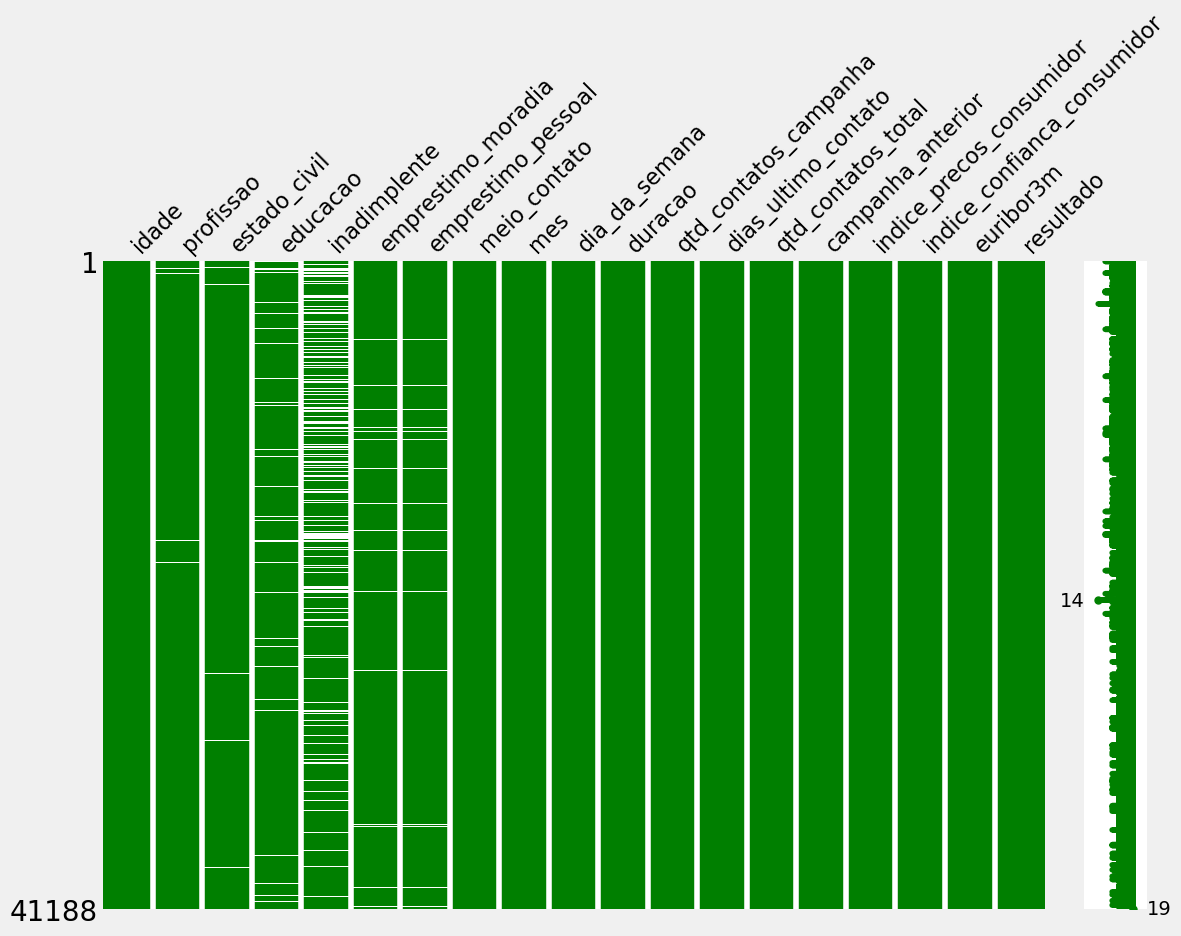

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(41188, 19)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        41188 non-null  int64  
 1   profissao                    40858 non-null  object 
 2   estado_civil                 41108 non-null  object 
 3   educacao                     39457 non-null  object 
 4   inadimplente                 32591 non-null  object 
 5   emprestimo_moradia           40198 non-null  object 
 6   emprestimo_pessoal           40198 non-null  object 
 7   meio_contato                 41188 non-null  object 
 8   mes                          41188 non-null  object 


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



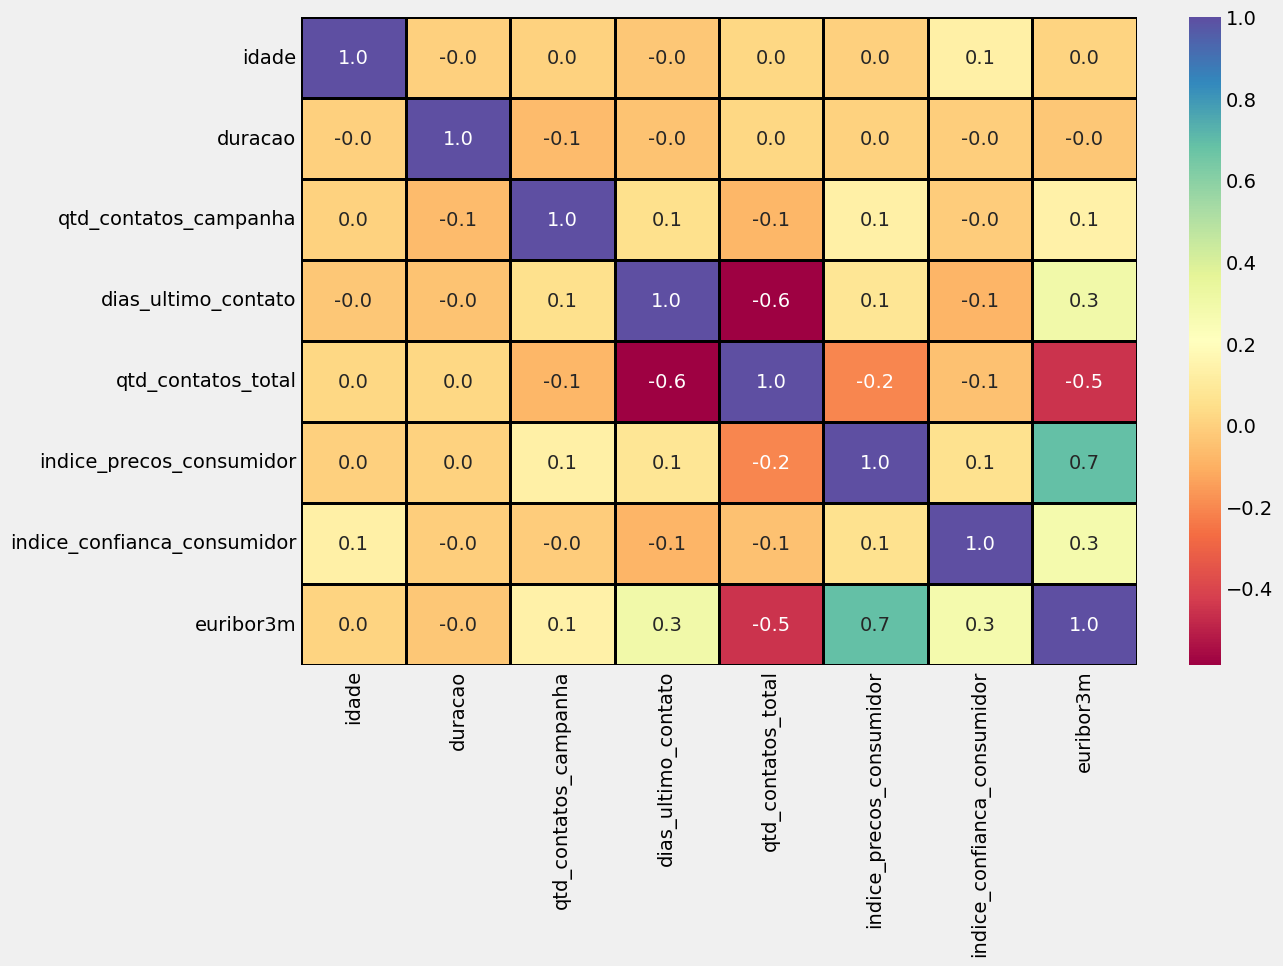

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



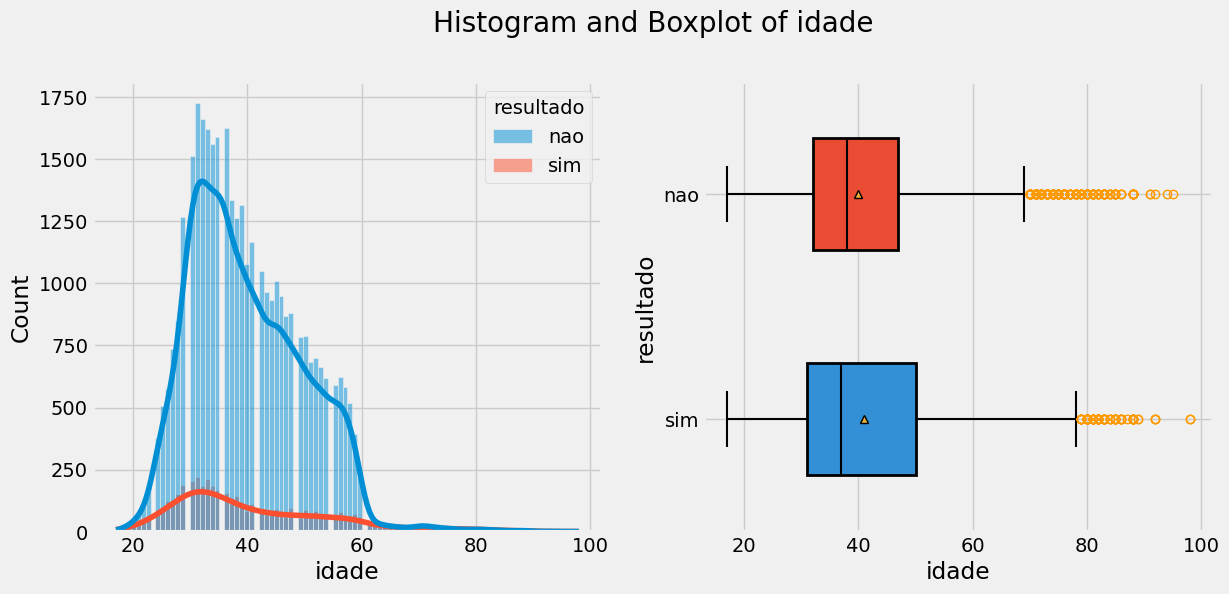

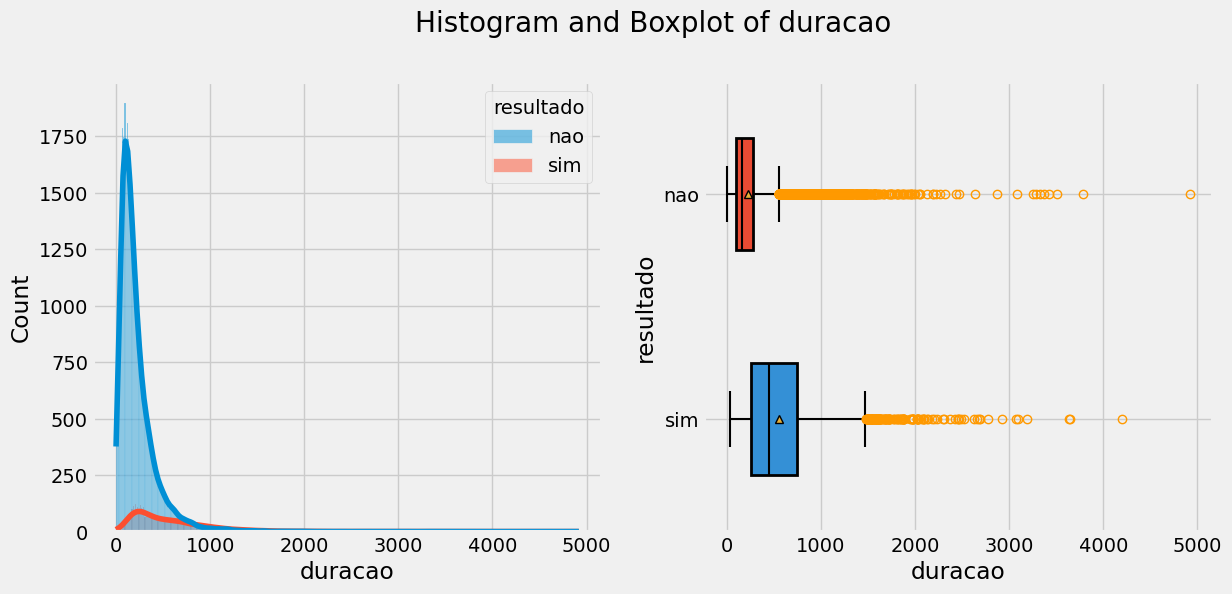

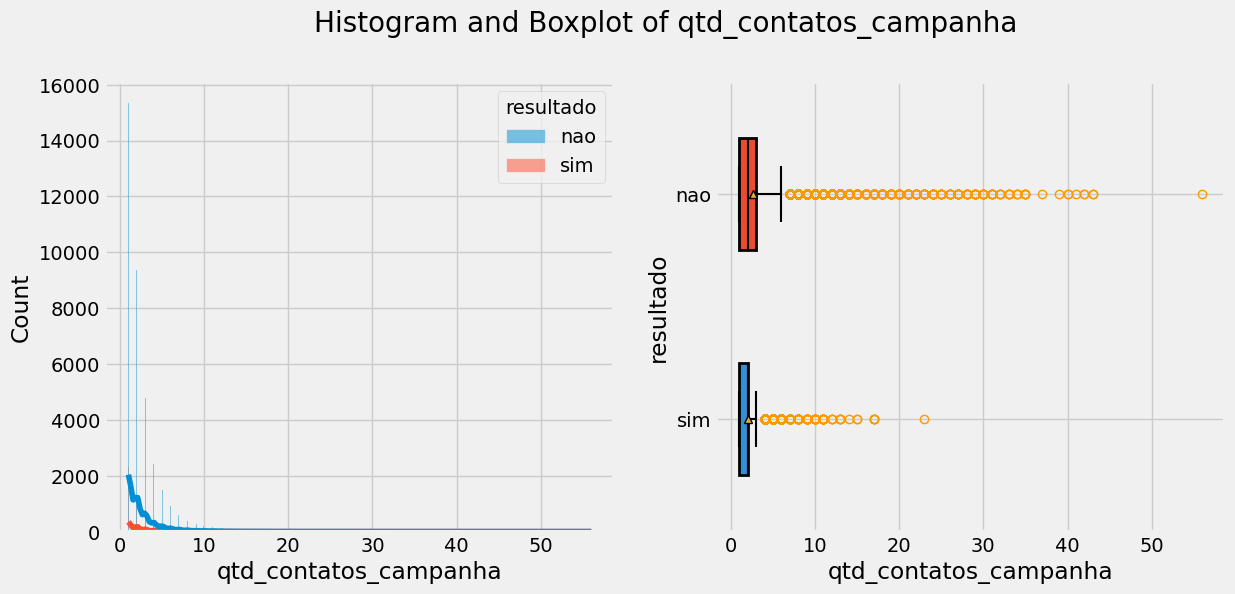

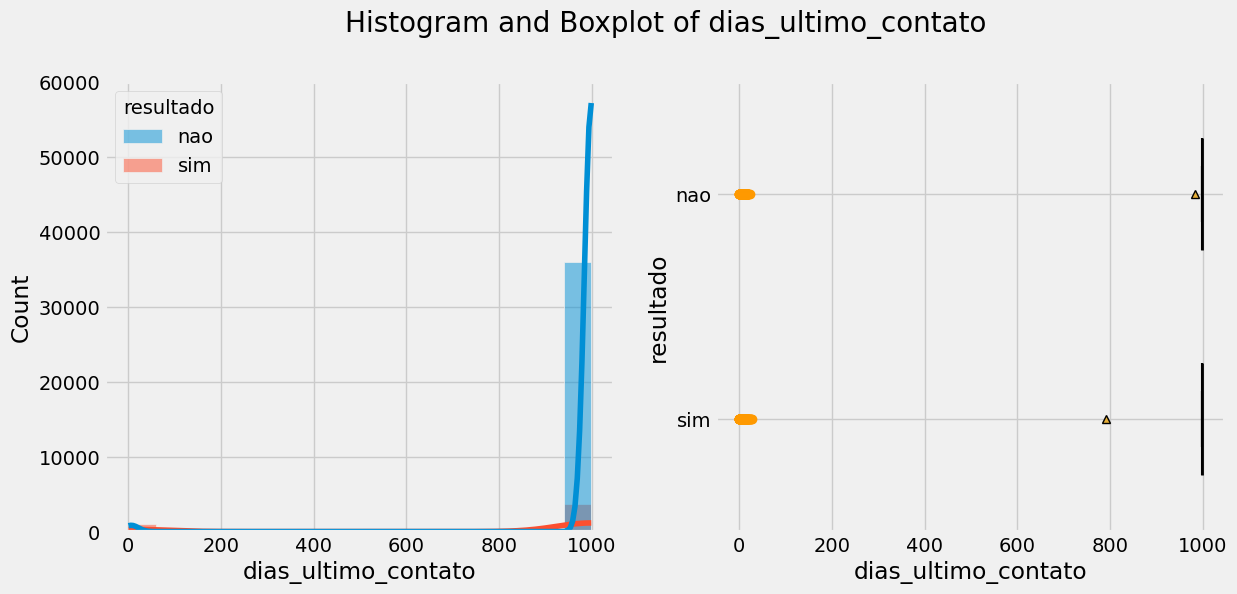

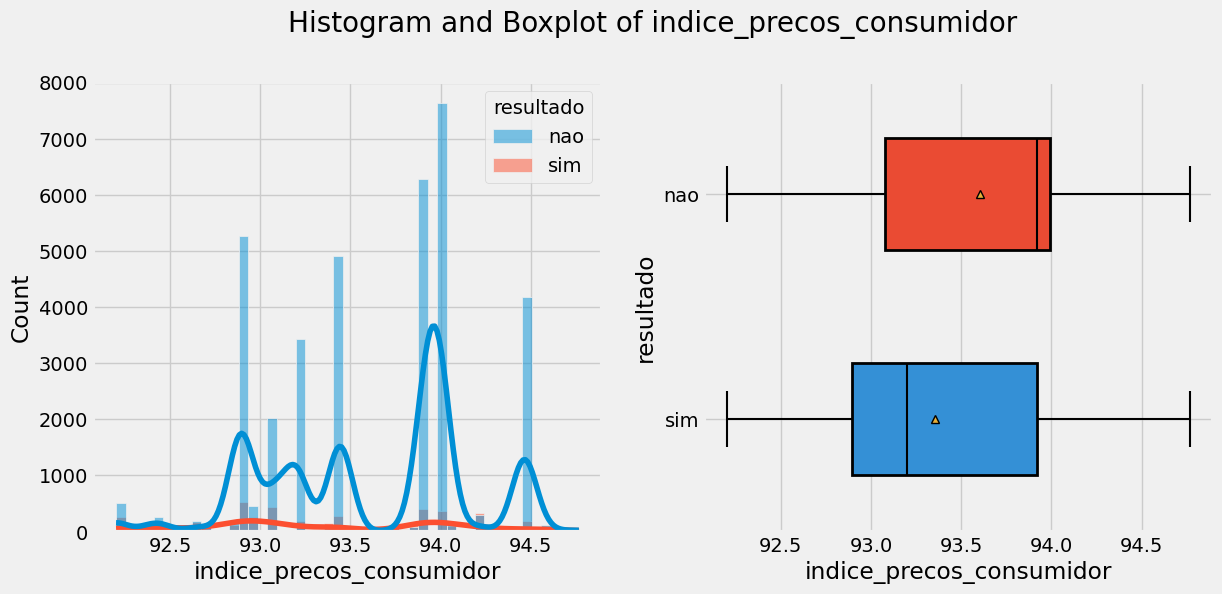

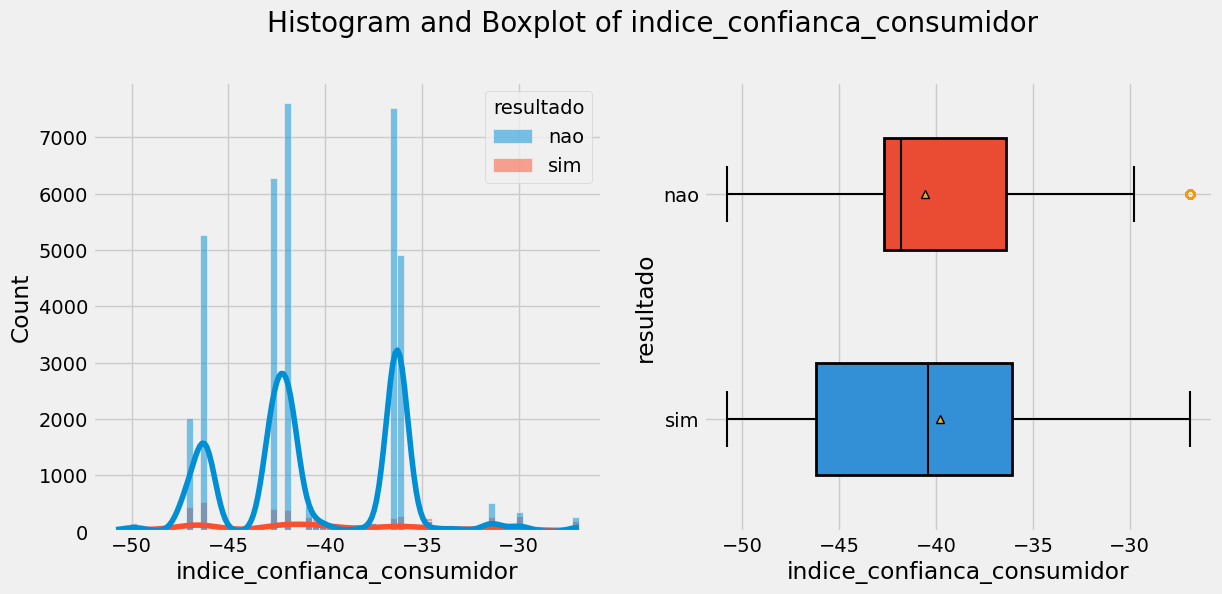

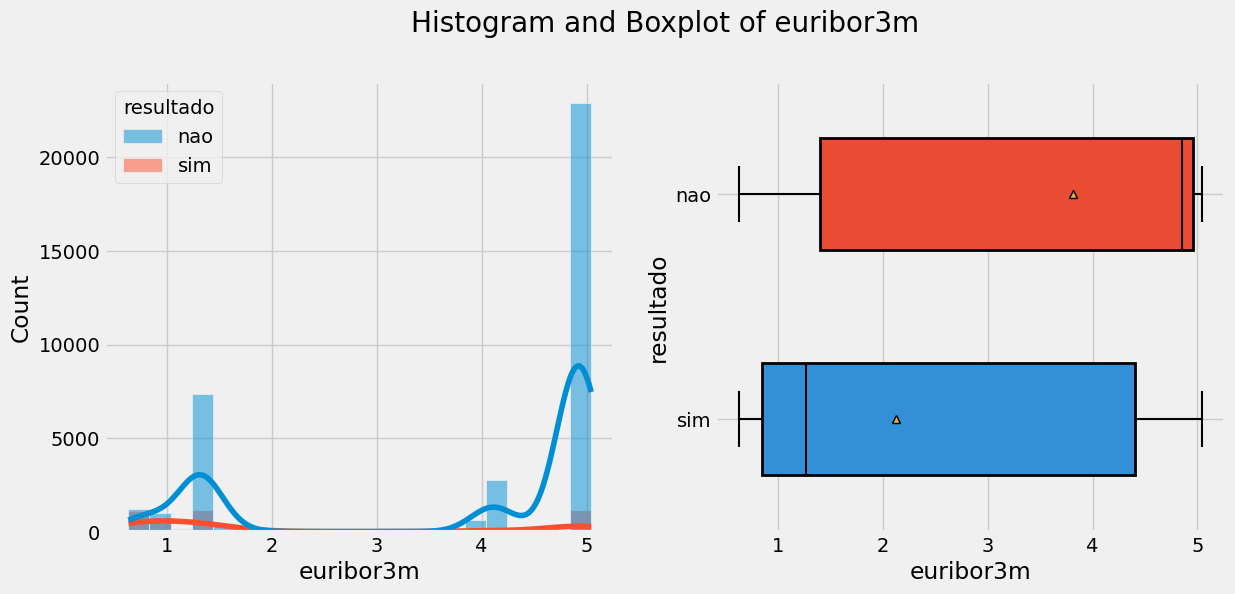

----------------------------------------------------------------------------------------------------
Countplot(s):



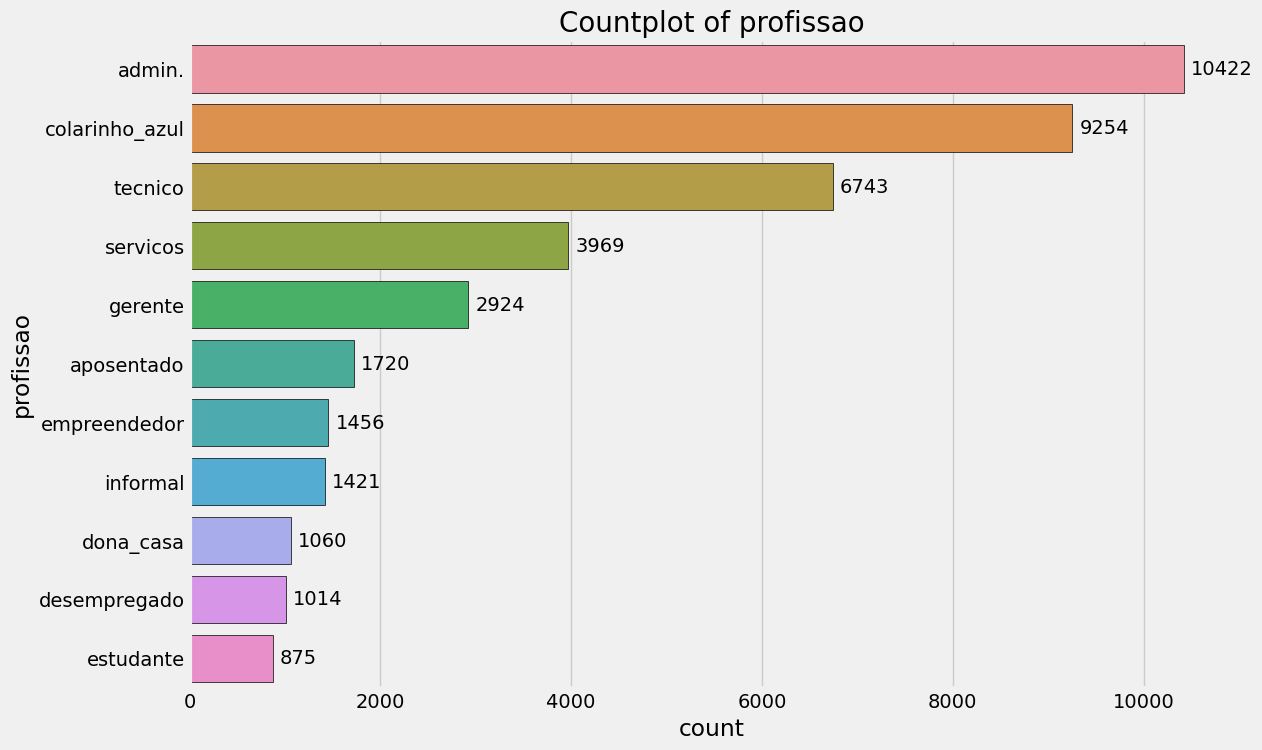

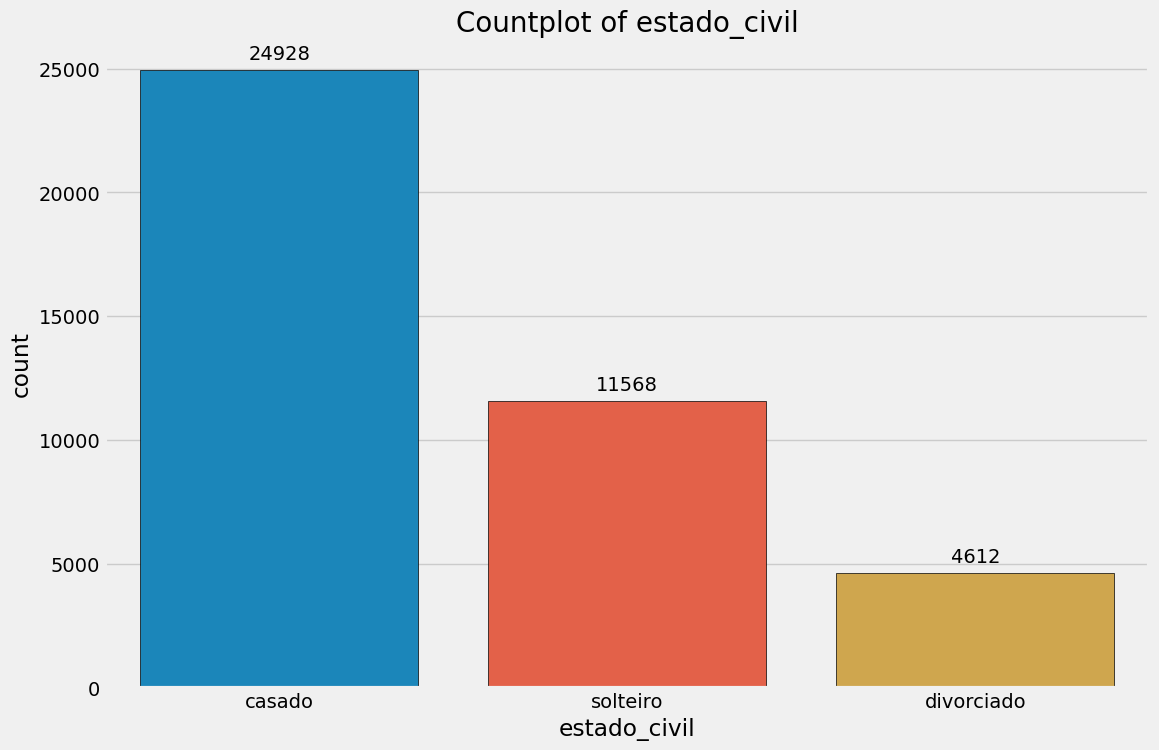

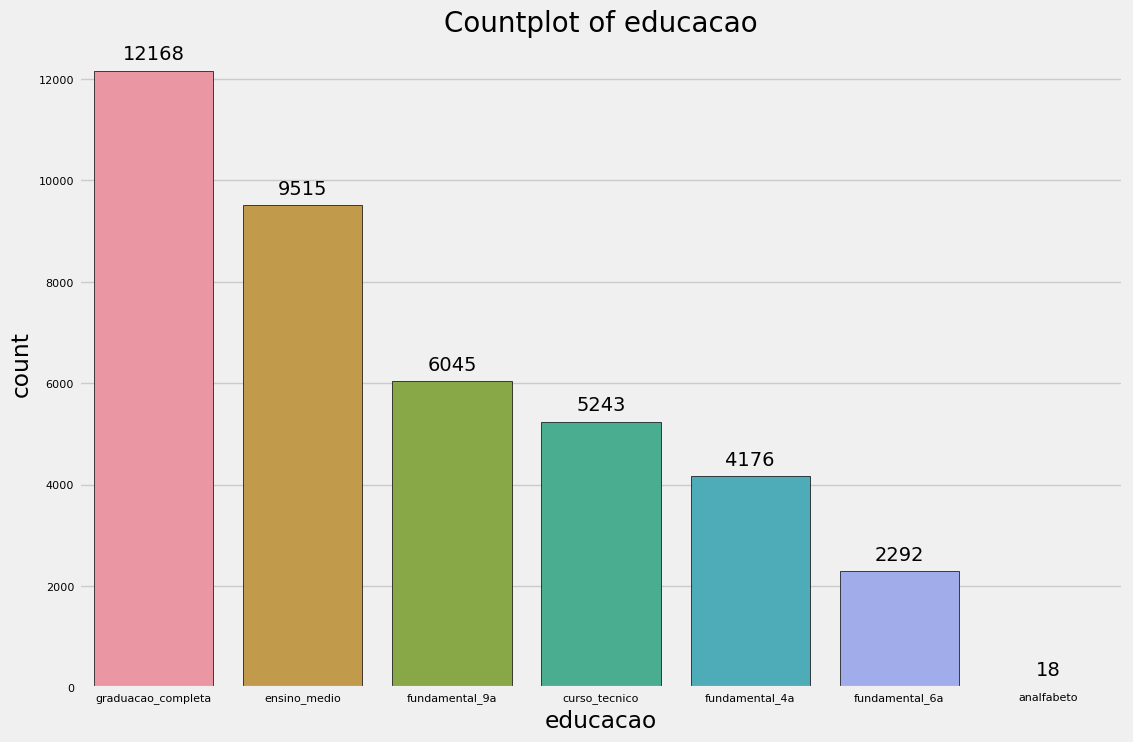

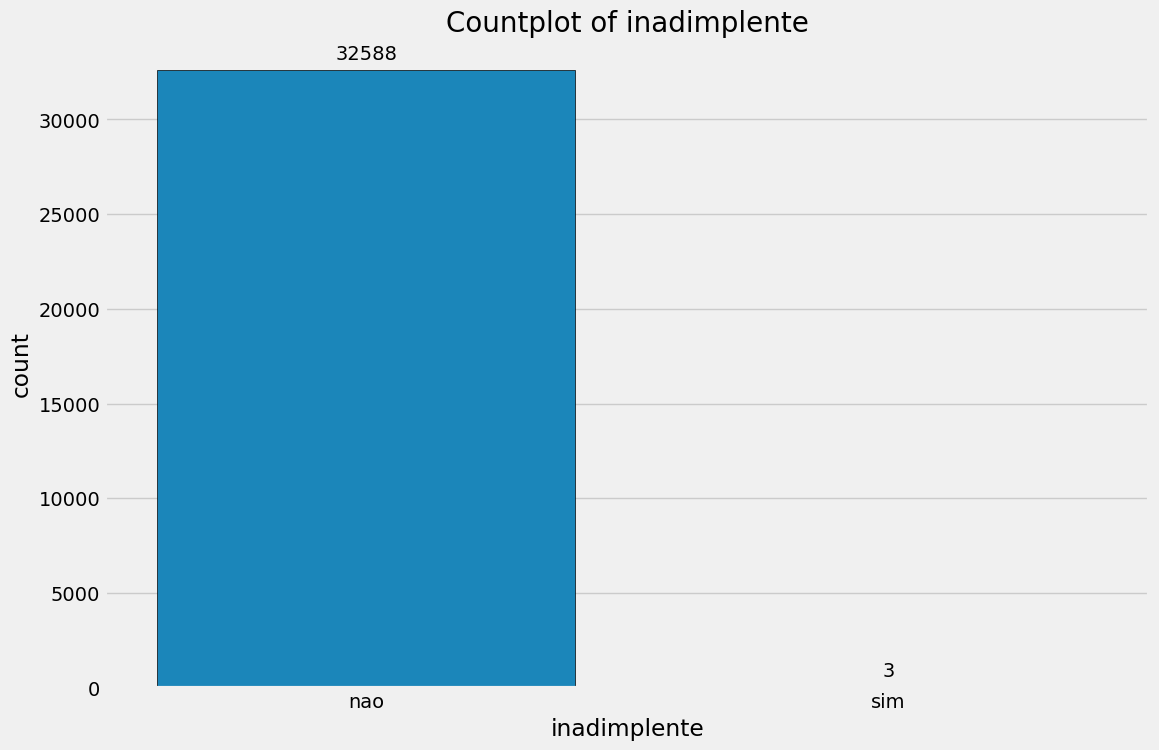

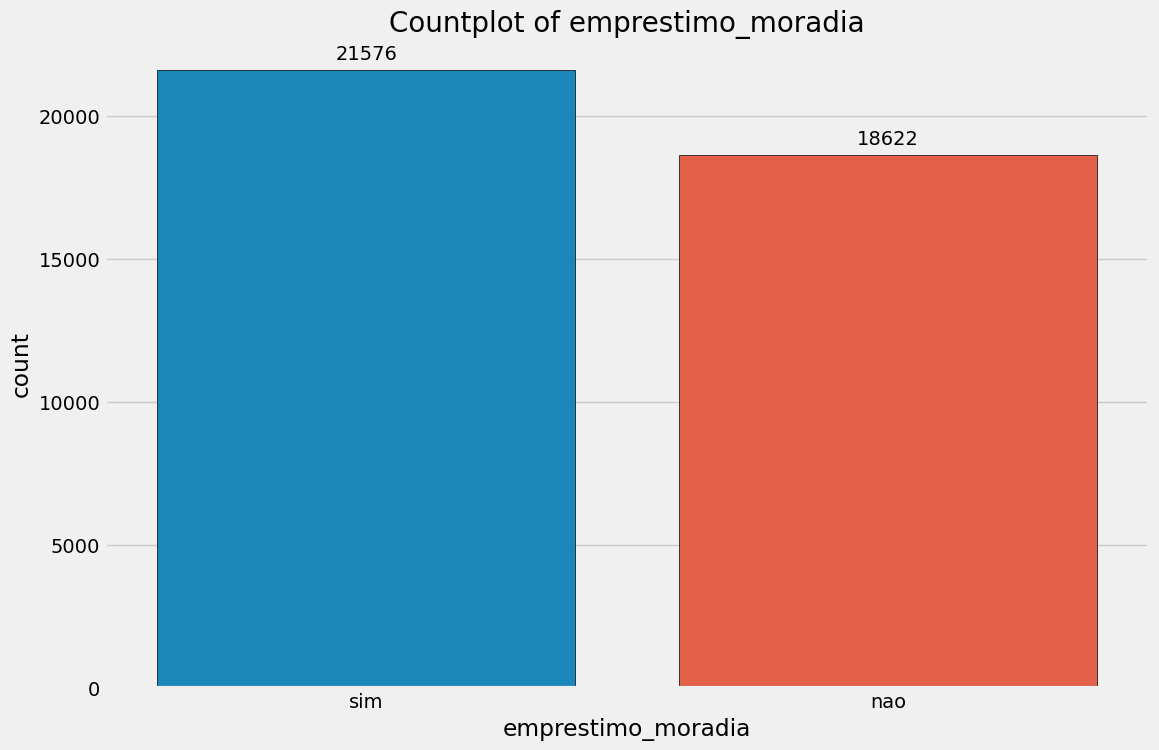

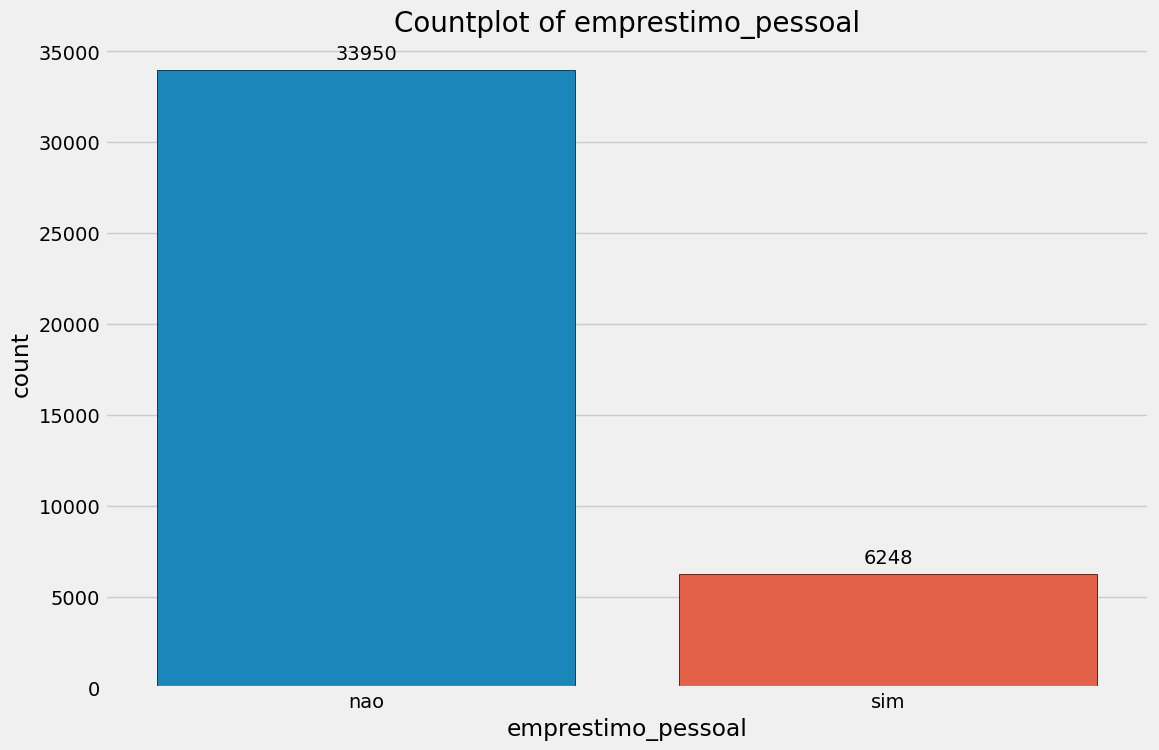

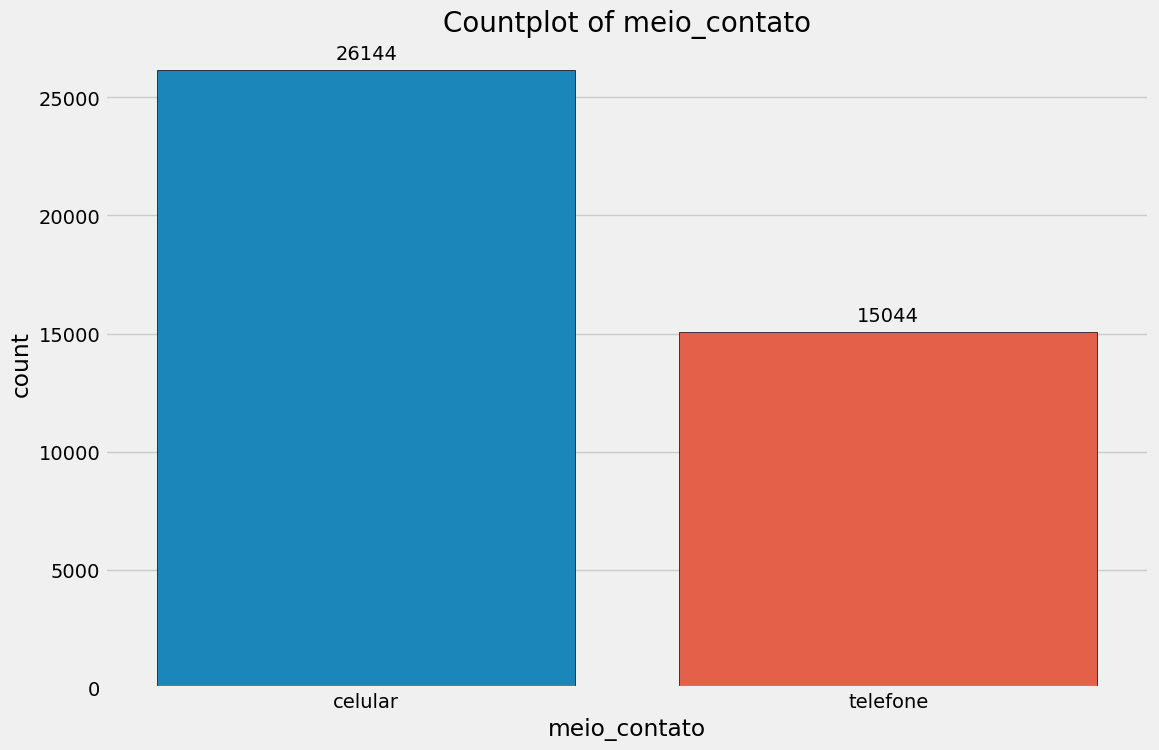

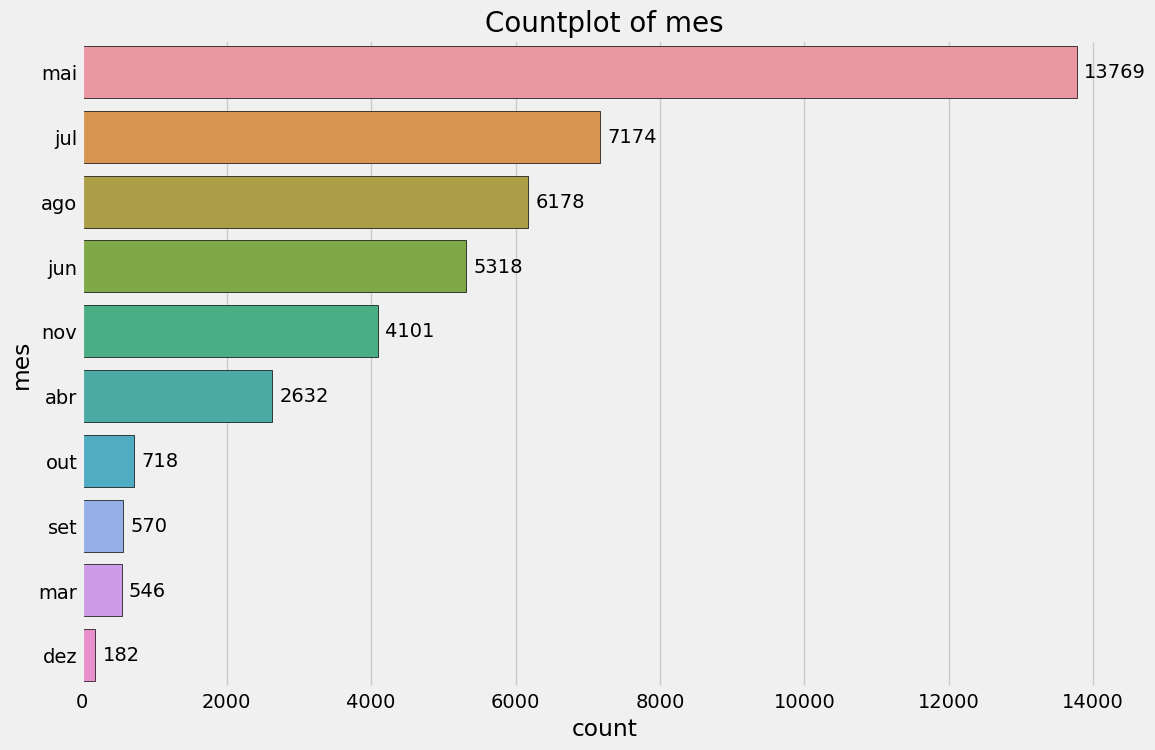

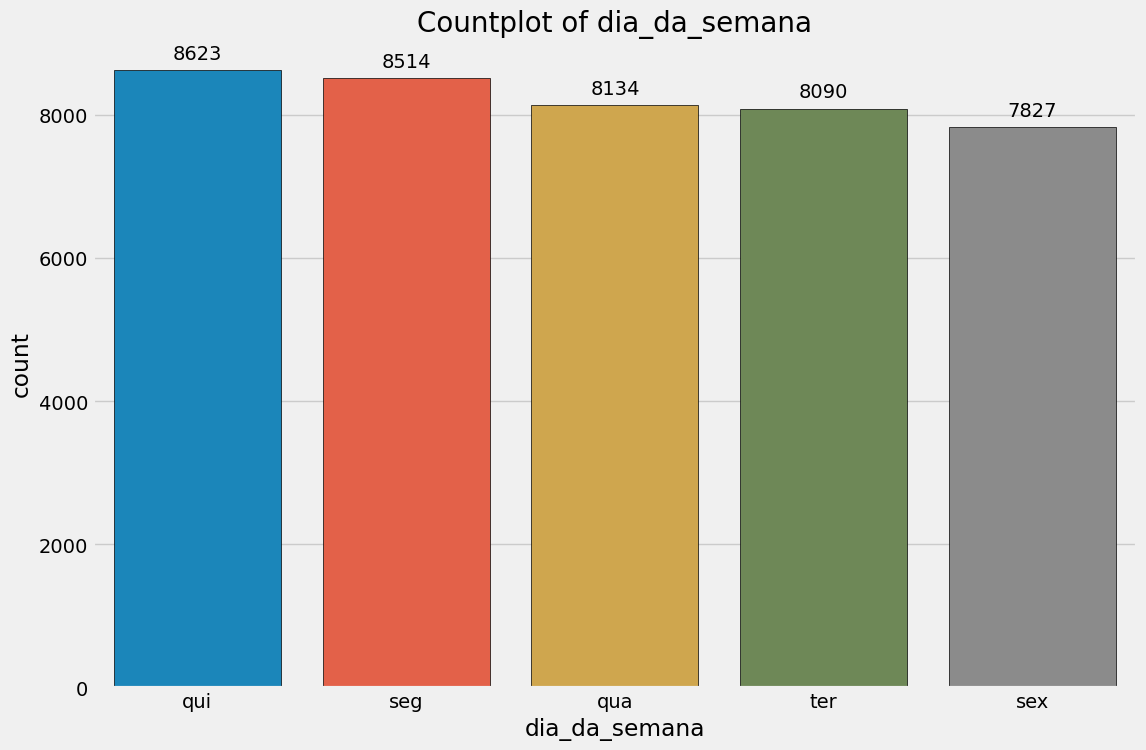

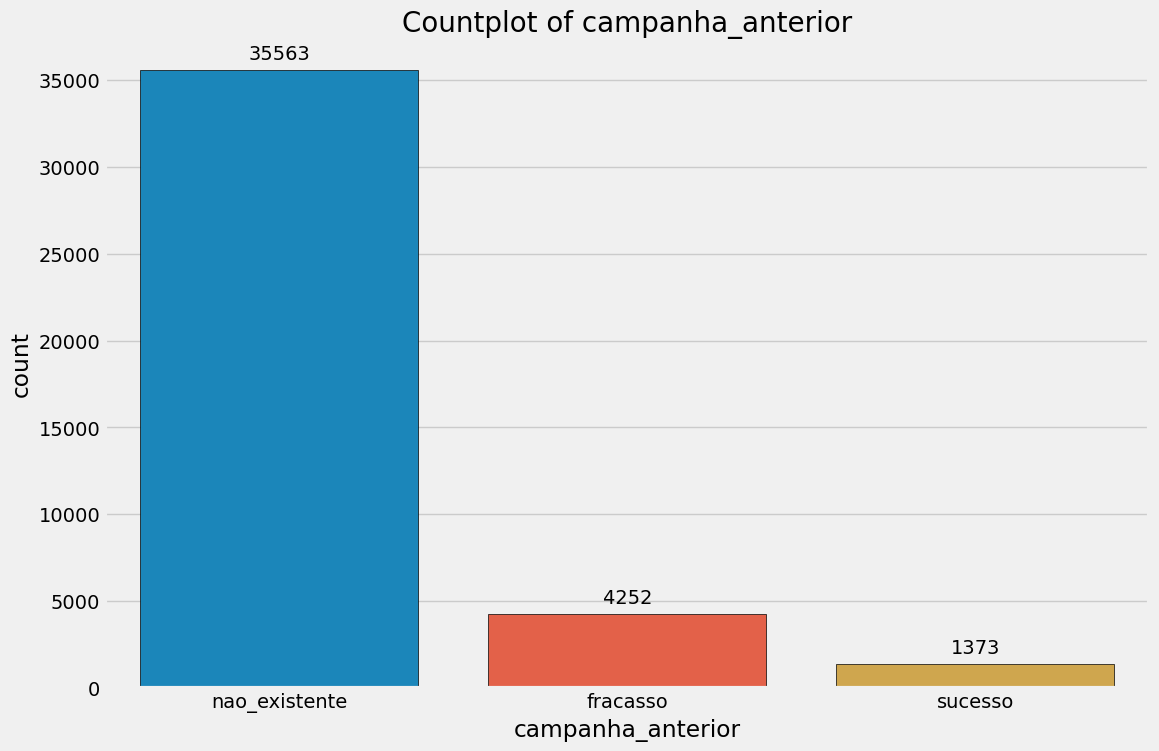

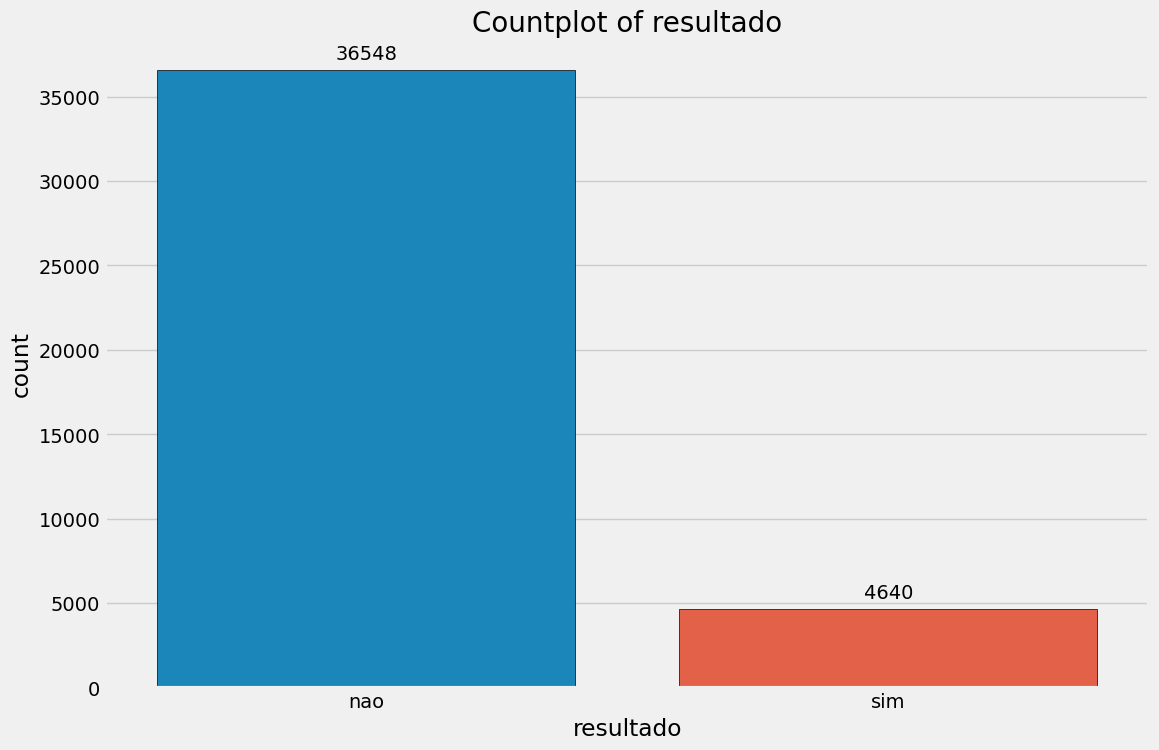

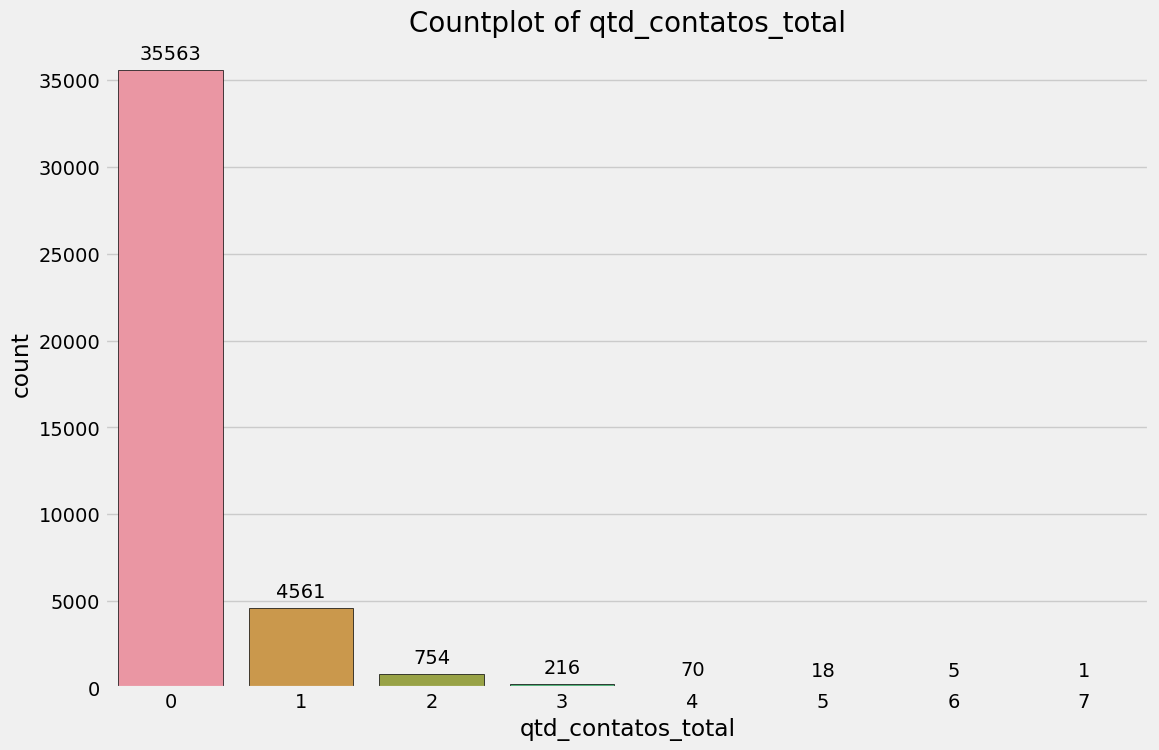

In [6]:
df = read_tsv("callcenter_marketing.csv")
fast_eda(df, target = "resultado")

## Outliers Removal <a name="outliers"></a>

In [7]:
print(f"DataFrame de antes tinha {df.shape[0]} linhas e {df.shape[1]} colunas.")
df_clean = remove_outliers(df)
print(f"Agora sem outliers tem {df_clean.shape[0]} linhas e {df_clean.shape[1]} colunas.")

DataFrame de antes tinha 41188 linhas e 19 colunas.
Agora sem outliers tem 23106 linhas e 19 colunas.


### Retrieve and remove a random row from the clean dataset <a name="remove_row"></a>

In [8]:
# Selecting a random index from the original DataFrame
random_index = df.sample(n=1).index[0]

# Getting the random row
random_row_removed = df.loc[[random_index]]

# Removing the random row from the original DataFrame
df_without_random_row = df.drop(index=random_index)

df = df_without_random_row.copy()

## Correlation analysis on clean dataset <a name="correlation_analysis"></a>

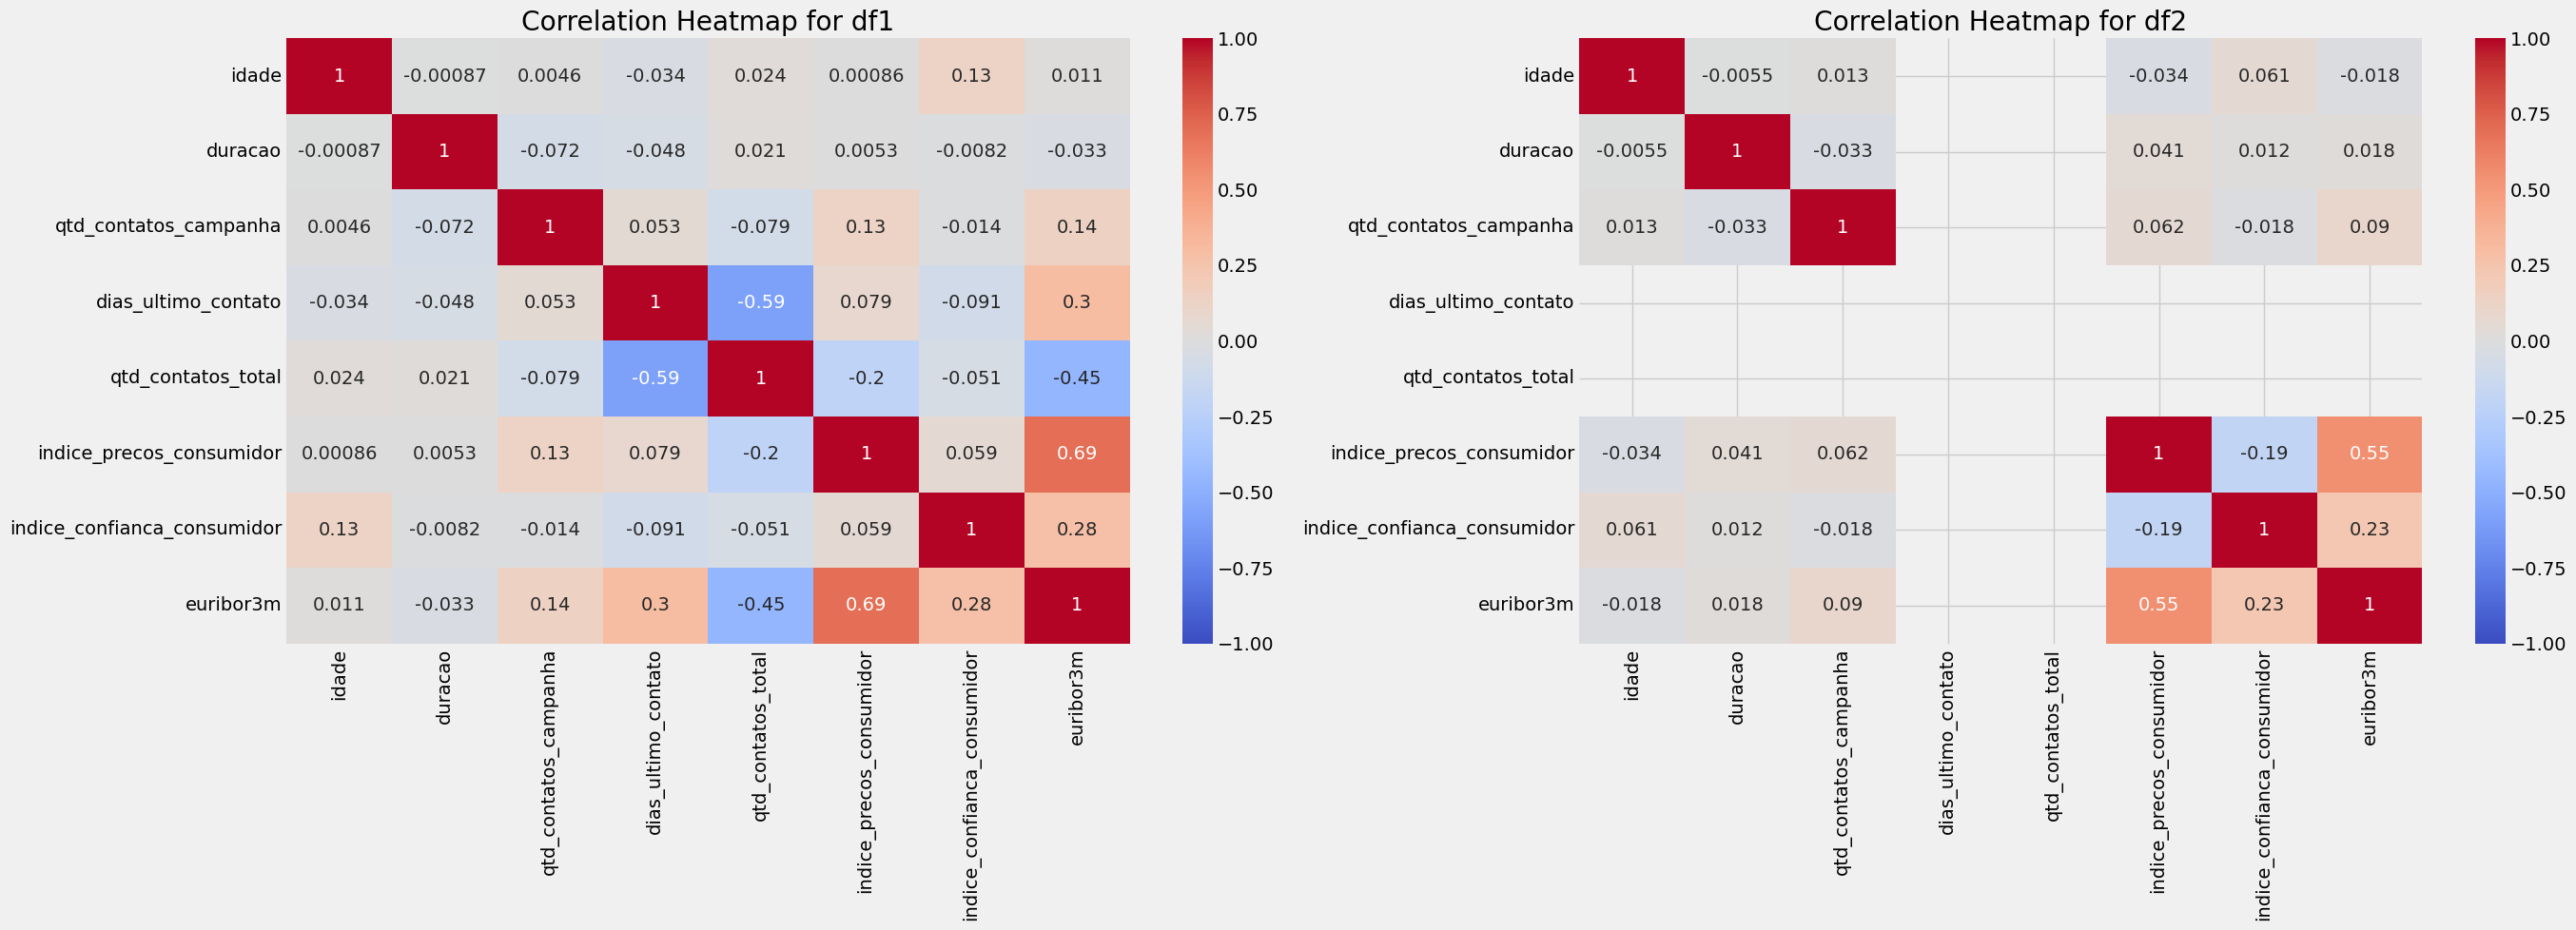

In [9]:
side_by_side_correlation_analysis(df, df_clean)

## Transform columns and handling data (removing null values, normalization, ...)  <a name="handling_data"></a>

In [10]:
df_processed = columns_transformer(df_clean)
df_processed.head()

idade   duracao  qtd_contatos_campanha  dias_ultimo_contato  \
0  1.720400  0.430792              -0.850239                  0.0   
1  1.829249 -0.379594              -0.850239                  0.0   
2 -0.347743  0.177546              -0.850239                  0.0   
3 -0.021194 -0.365123              -0.850239                  0.0   
4  1.720400  0.763629              -0.850239                  0.0   

   qtd_contatos_total  indice_precos_consumidor  indice_confianca_consumidor  \
0                 0.0                  0.366507                     0.975317   
1                 0.0                  0.366507                     0.975317   
2                 0.0                  0.366507                     0.975317   
3                 0.0                  0.366507                     0.975317   
4                 0.0                  0.366507                     0.975317   

   euribor3m  profissao_admin.  profissao_aposentado  \
0   0.101044               0.0                   0.0   
1   0.101044               0.0                   0.0   
2   0.101044               0.0                   0.0   
3   0.101044               1.0                   0.0   
4   0.101044               0.0                   0.0   

   profissao_colarinho_azul  profissao_desempregado  profissao_dona_casa  \
0                       0.0                     0.0                  1.0   
1                       0.0                     0.0                  0.0   
2                       0.0                     0.0                  0.0   
3                       0.0                     0.0                  0.0   
4                       0.0                     0.0                  0.0   

   profissao_empreendedor  profissao_estudante  profissao_gerente  \
0                     0.0                  0.0                0.0   
1                     0.0                  0.0                0.0   
2                     0.0                  0.0                0.0   
3                     0.0                  0.0                0.0   
4                     0.0                  0.0                0.0   

   profissao_informal  profissao_missing  profissao_servicos  \
0                 0.0                0.0                 0.0   
1                 0.0                0.0                 1.0   
2                 0.0                0.0                 1.0   
3                 0.0                0.0                 0.0   
4                 0.0                0.0                 1.0   

   profissao_tecnico  estado_civil_casado  estado_civil_divorciado  \
0                0.0                  1.0                      0.0   
1                0.0                  1.0                      0.0   
2                0.0                  1.0                      0.0   
3                0.0                  1.0                      0.0   
4                0.0                  1.0                      0.0   

   estado_civil_missing  estado_civil_solteiro  educacao_analfabeto  \
0                   0.0                    0.0                  0.0   
1                   0.0                    0.0                  0.0   
2                   0.0                    0.0                  0.0   
3                   0.0                    0.0                  0.0   
4                   0.0                    0.0                  0.0   

   educacao_curso_tecnico  educacao_ensino_medio  educacao_fundamental_4a  \
0                     0.0                    0.0                      1.0   
1                     0.0                    1.0                      0.0   
2                     0.0                    1.0                      0.0   
3                     0.0                    0.0                      0.0   
4                     0.0                    1.0                      0.0   

   educacao_fundamental_6a  educacao_fundamental_9a  \
0                      0.0                      0.0   
1                      0.0                      0.0   
2                      0.0              

## Feature selection  <a name="feature_selection"></a>

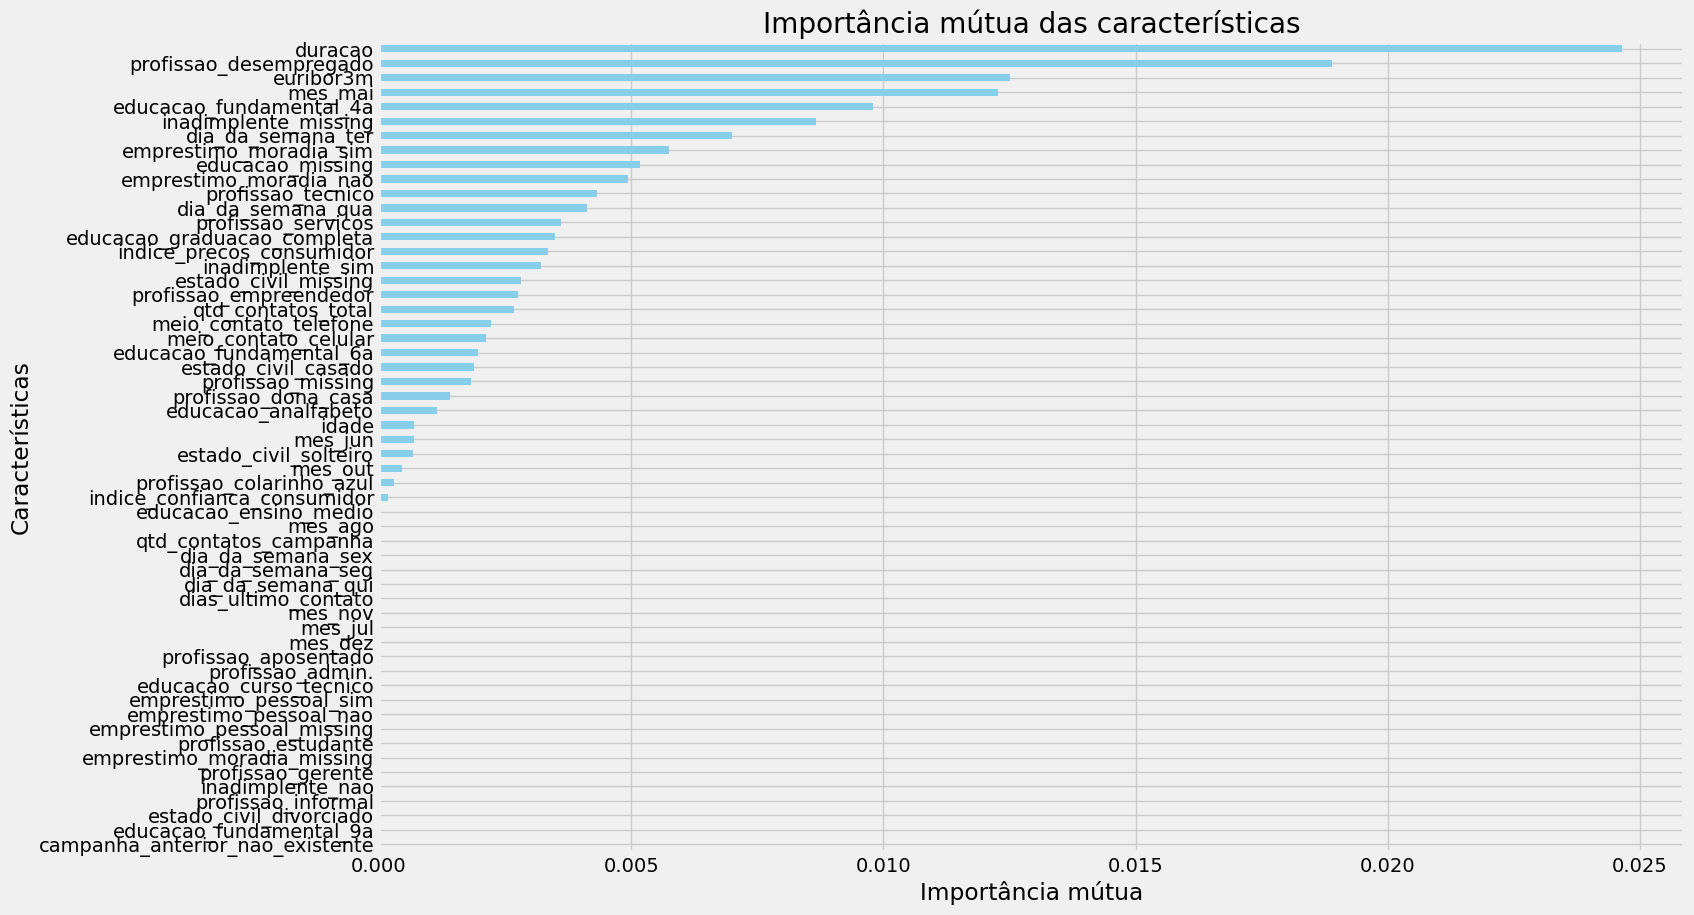

In [11]:
imp_col = get_important_columns(df_processed)

In [12]:
imp_col.append('resultado')
df_processed = df_processed[imp_col]
print(imp_col)

['duracao', 'euribor3m', 'profissao_desempregado', 'educacao_fundamental_4a', 'educacao_missing', 'inadimplente_missing', 'emprestimo_moradia_sim', 'mes_mai', 'dia_da_semana_ter', 'resultado']


# PCA <a name="pca"></a>

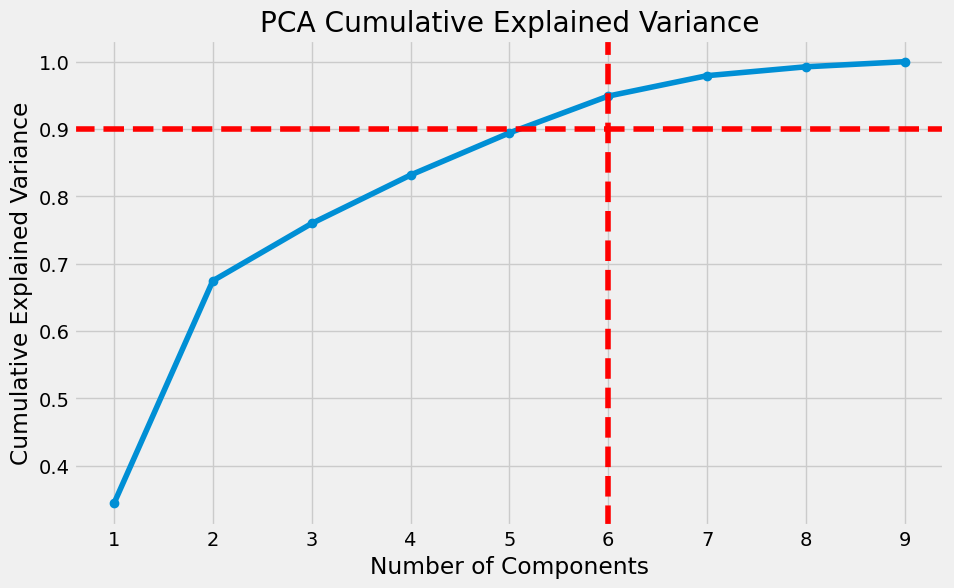

In [13]:
# Testing the PCA function again after importing numpy
cumulative_explained_variance, n_components_90 = PCA_analysis(df_processed)

In [14]:
print("The number of components required to explain at least 90% of the variance is", n_components_90,".")

The number of components required to explain at least 90% of the variance is 6 .


In [15]:
pca, df_principal_components = generate_principal_components(df_processed, n_components_90)

In [16]:
df_principal_components

PC1       PC2       PC3       PC4       PC5       PC6  resultado
0     -0.416688  0.249863  0.658422  0.324686 -0.386763 -0.286094          0
1      0.102327 -0.381381  0.724574  0.788907  0.183060 -0.283745          0
2     -0.207685  0.082771 -0.320239  0.458568 -0.677836 -0.283365          0
3      0.134915 -0.329154  0.645586  0.201796 -0.585287 -0.292527          0
4     -0.627602  0.501735  0.624967  0.169664 -0.557203 -0.293266          0
...         ...       ...       ...       ...       ...       ...        ...
23101  3.940764  3.303316 -0.345233  0.185490  0.232593 -0.158005          0
23102  4.051939  3.534950 -0.324727  0.128146 -0.014030  0.828317          0
23103  4.086947  4.060974 -0.356083  0.062895  0.082032 -0.164938          0
23104  4.677936  3.650728  0.616844 -0.174482  0.183189 -0.173186          0
23105  5.407717  4.153142 -0.270141  0.294854  0.268932 -0.156875          1

[23106 rows x 7 columns]

## Fast EDA V2 <a name="fast_eda"></a>

DataFrame Head:


PC1       PC2       PC3       PC4       PC5       PC6  resultado
0 -0.416688  0.249863  0.658422  0.324686 -0.386763 -0.286094          0
1  0.102327 -0.381381  0.724574  0.788907  0.183060 -0.283745          0
2 -0.207685  0.082771 -0.320239  0.458568 -0.677836 -0.283365          0

DataFrame Tail:


PC1       PC2       PC3       PC4       PC5       PC6  resultado
23103  4.086947  4.060974 -0.356083  0.062895  0.082032 -0.164938          0
23104  4.677936  3.650728  0.616844 -0.174482  0.183189 -0.173186          0
23105  5.407717  4.153142 -0.270141  0.294854  0.268932 -0.156875          1

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(23106, 7)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23106 entries, 0 to 23105
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PC1        23106 non-null  float64
 1   PC2        23106 non-null  float64
 2   PC3        23106 non-null  float64
 3   PC4        23106 non-null  float64
 4   PC5        23106 non-null  float64
 5   PC6        23106 non-null  float64
 6   resultado  23106 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 1.2 MB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



----------------------------------------------------------------------------------------------------
DataFrame Correlation:



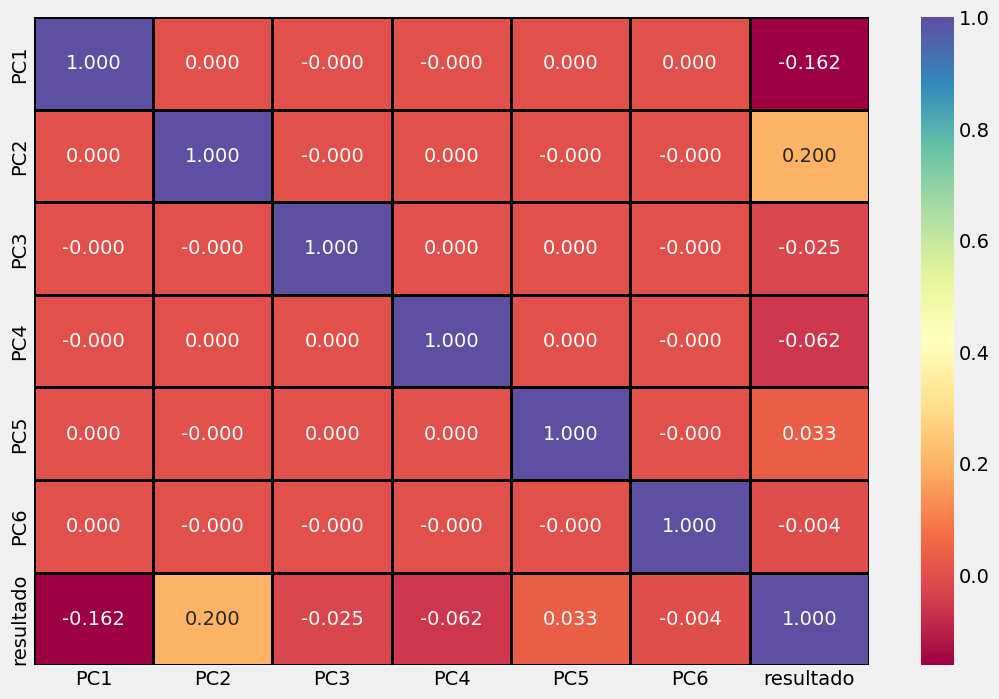

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



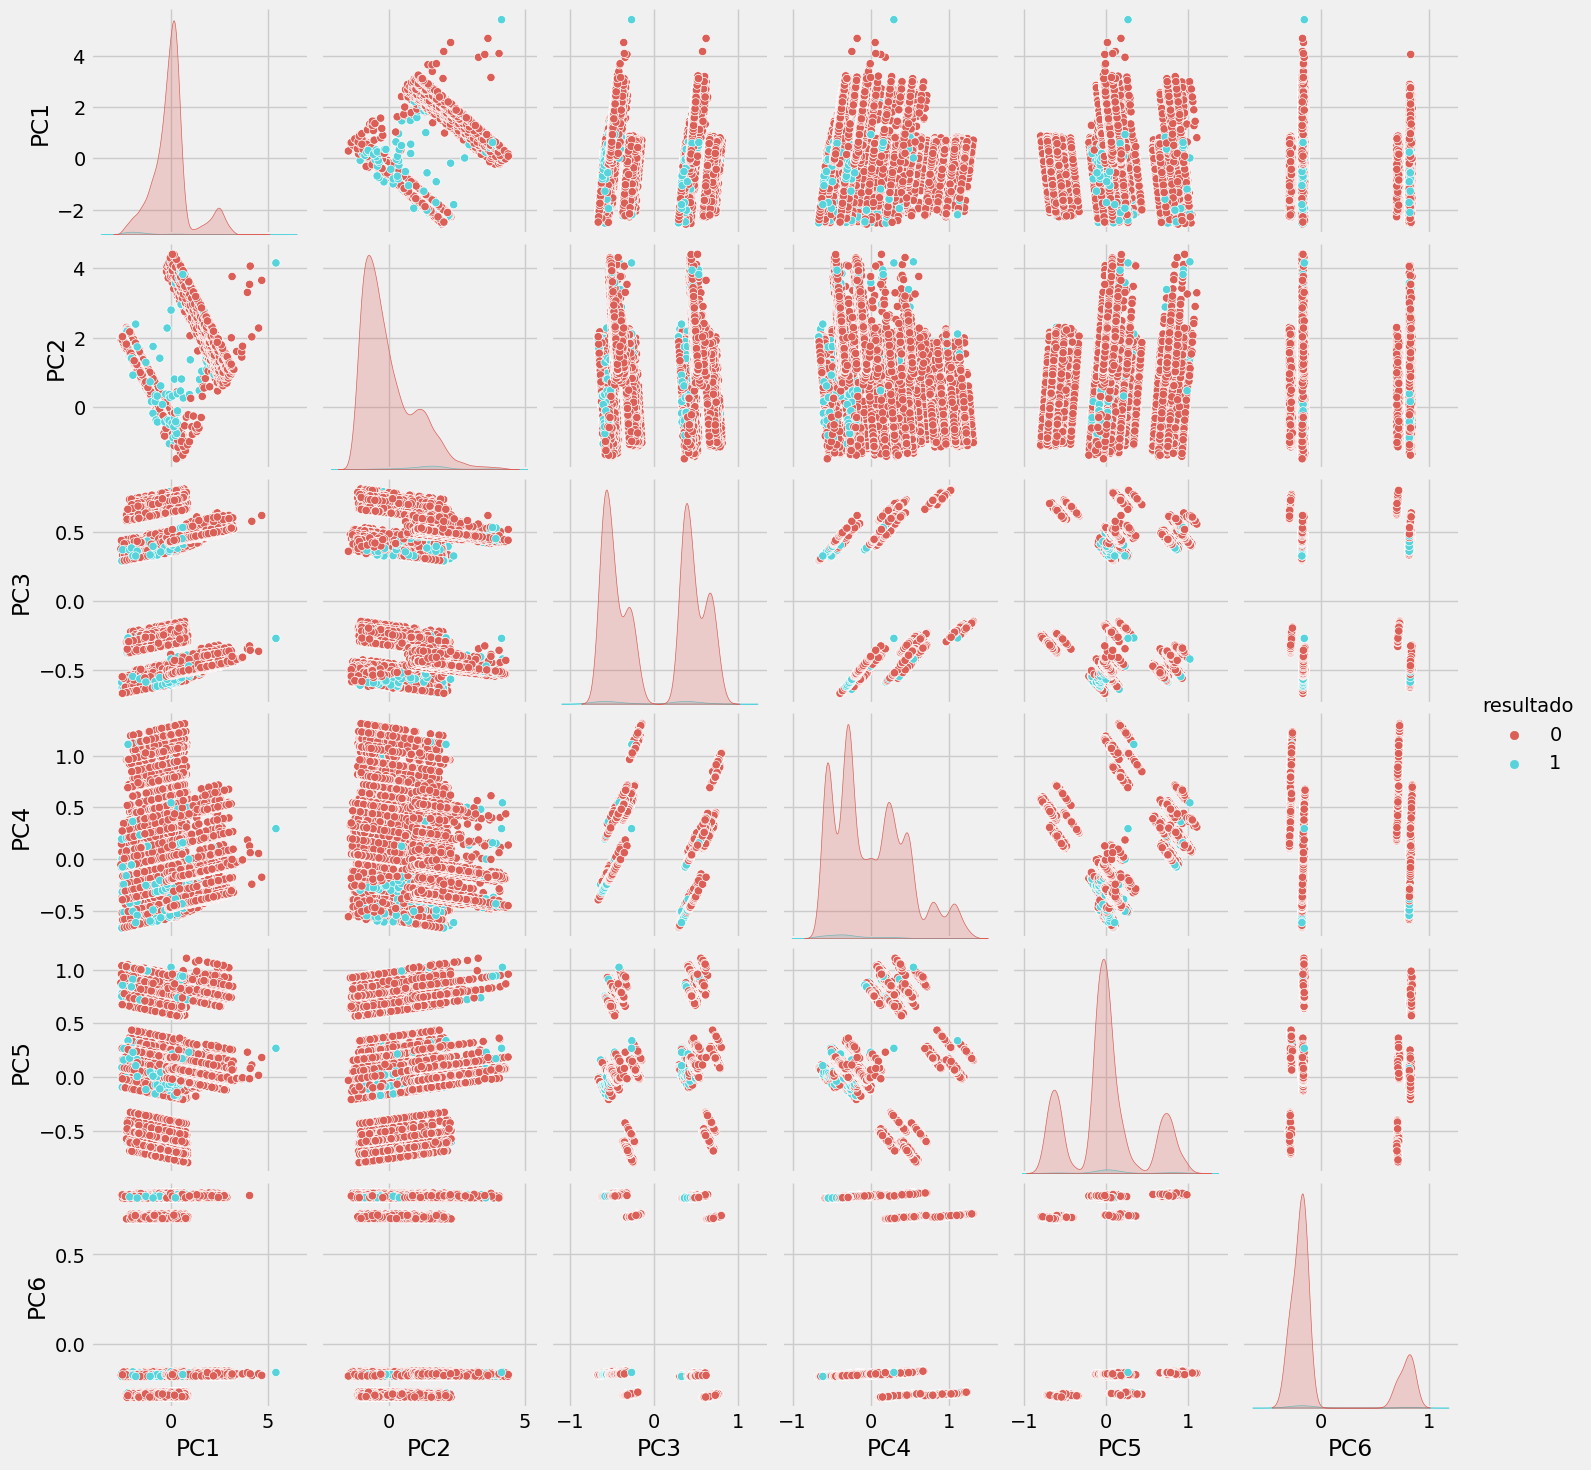

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



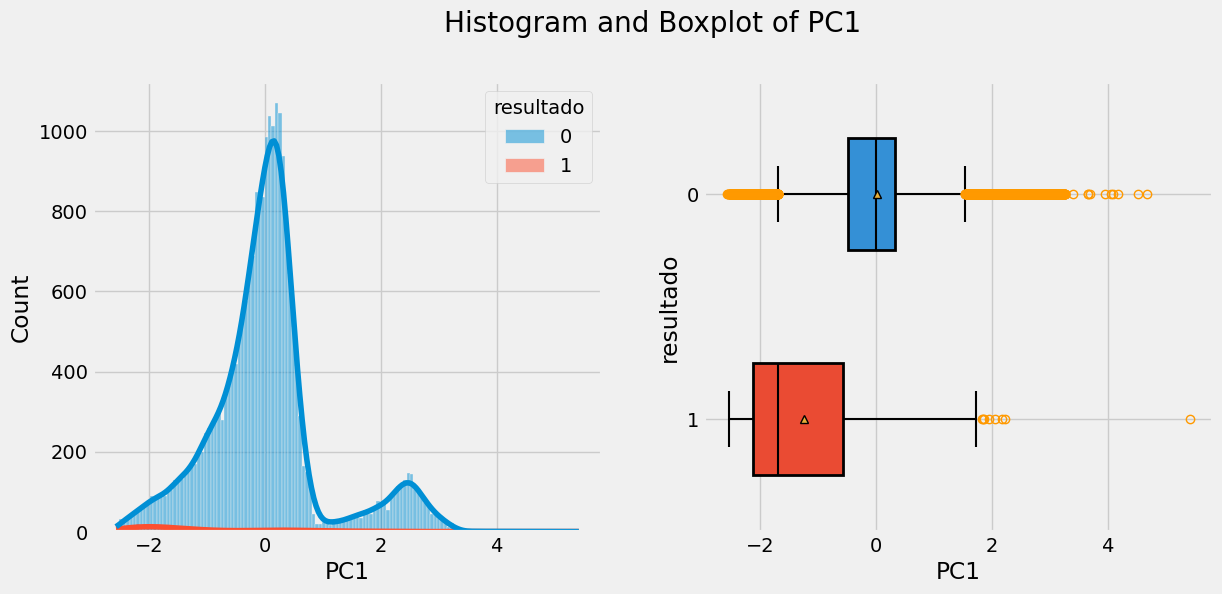

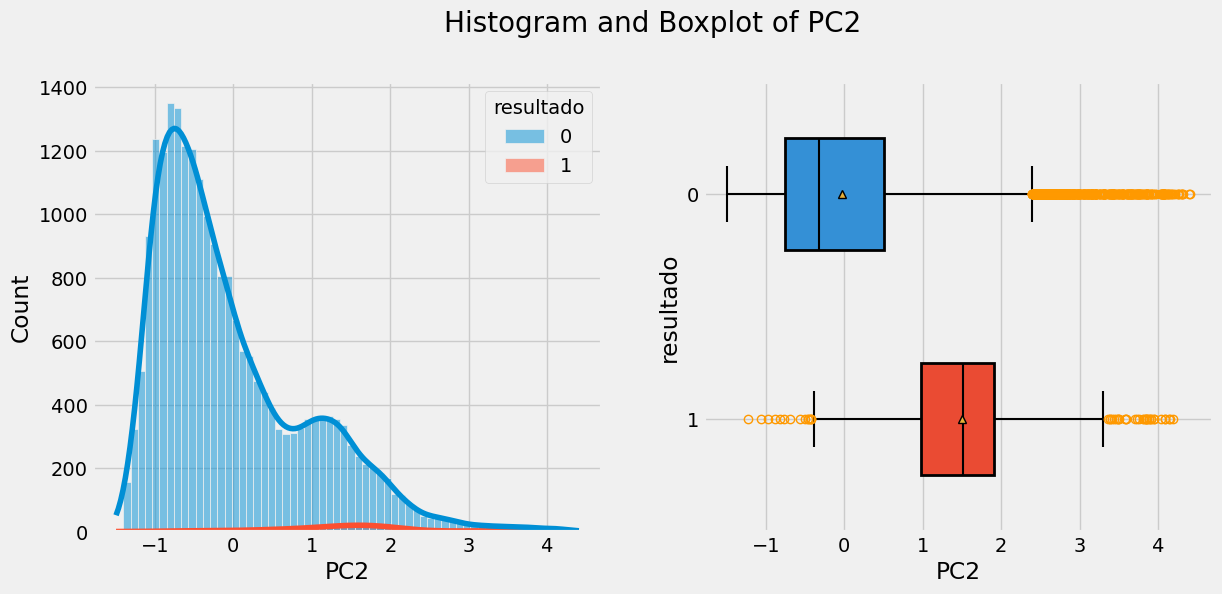

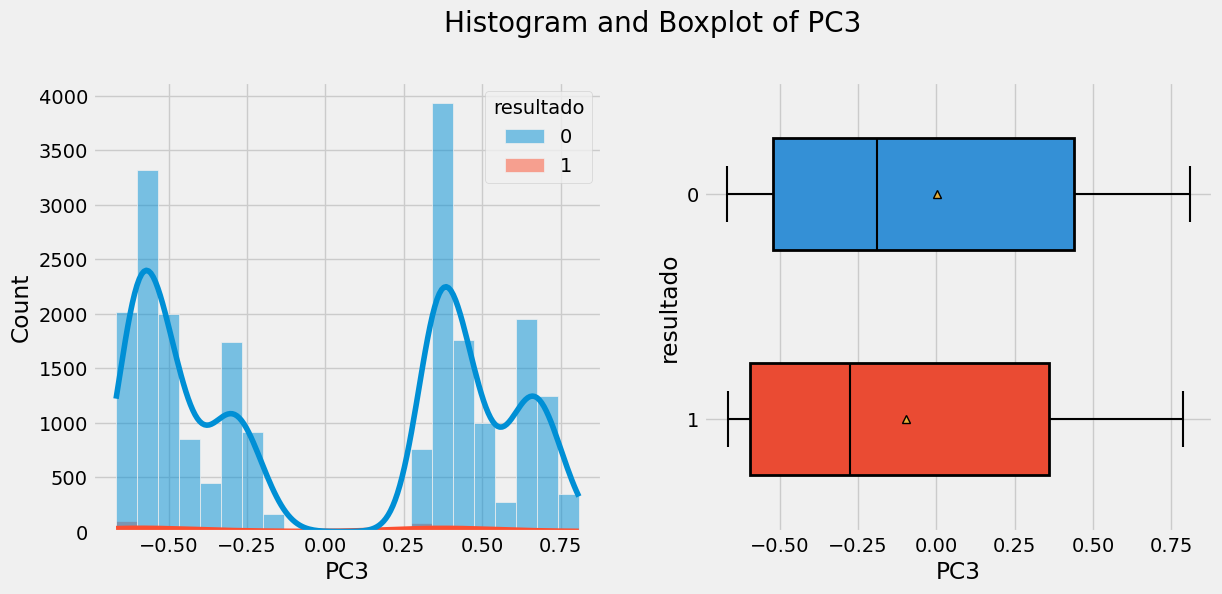

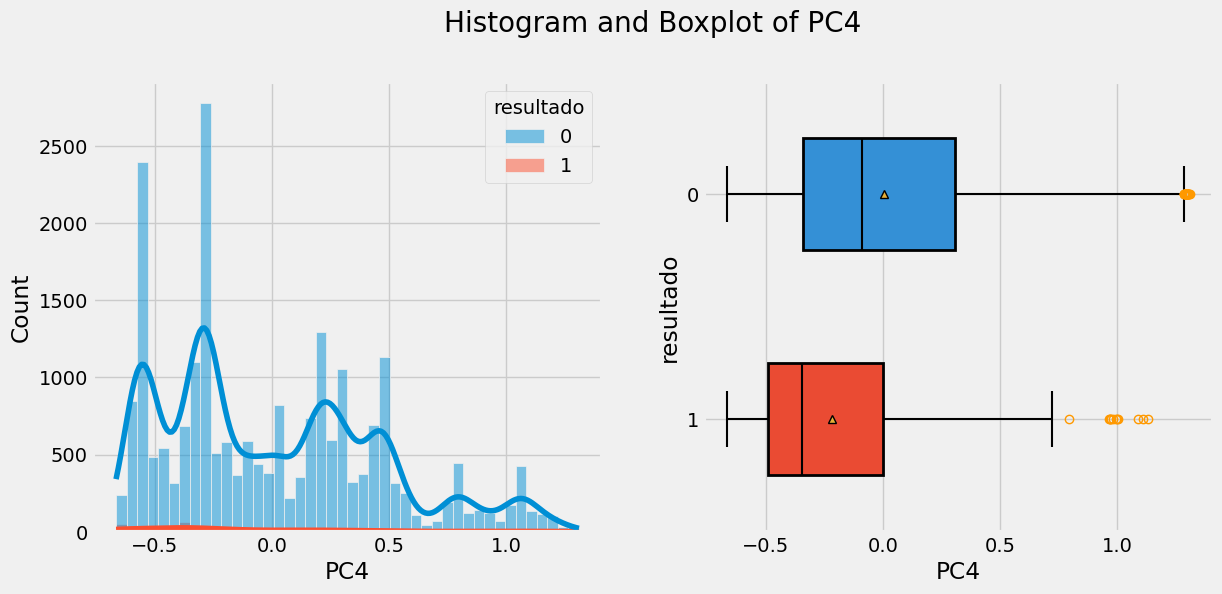

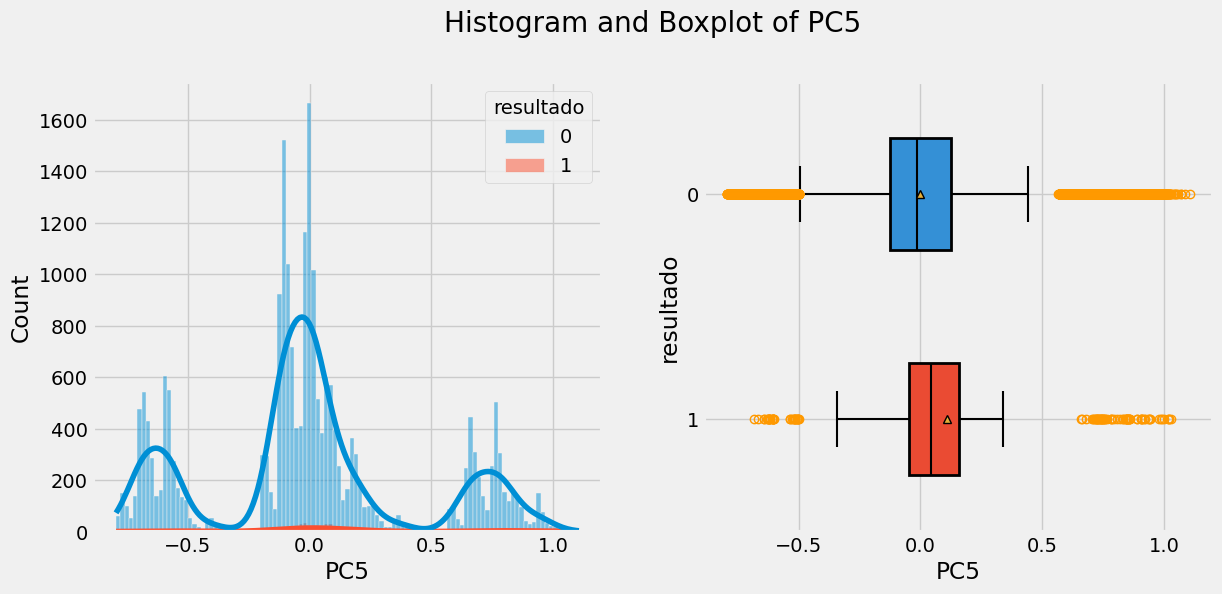

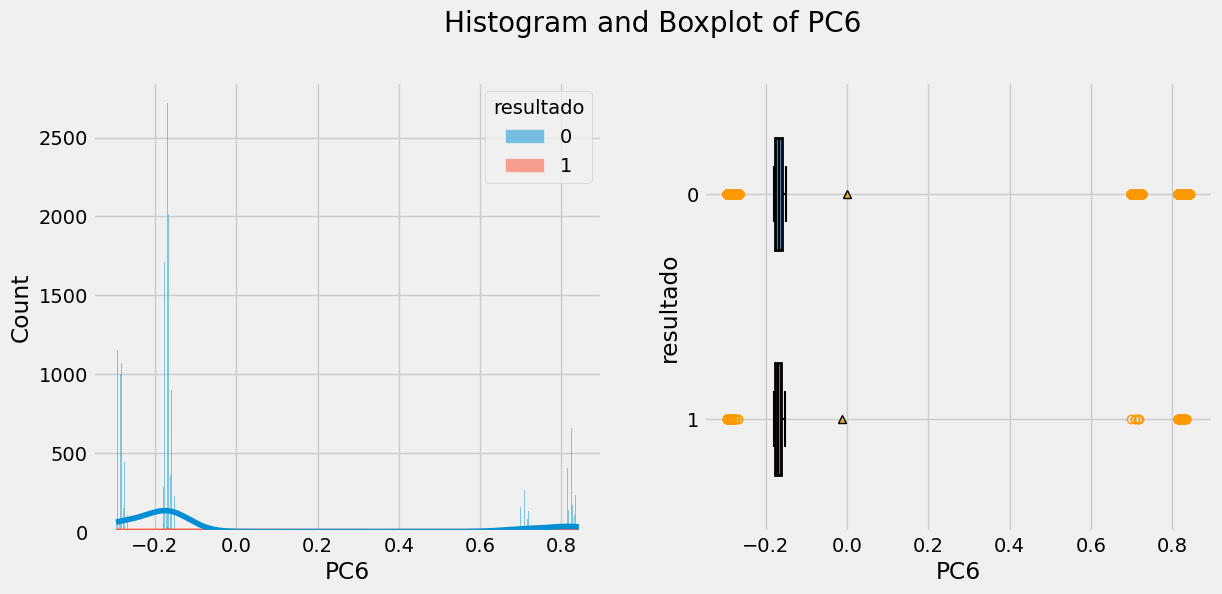

----------------------------------------------------------------------------------------------------
Countplot(s):



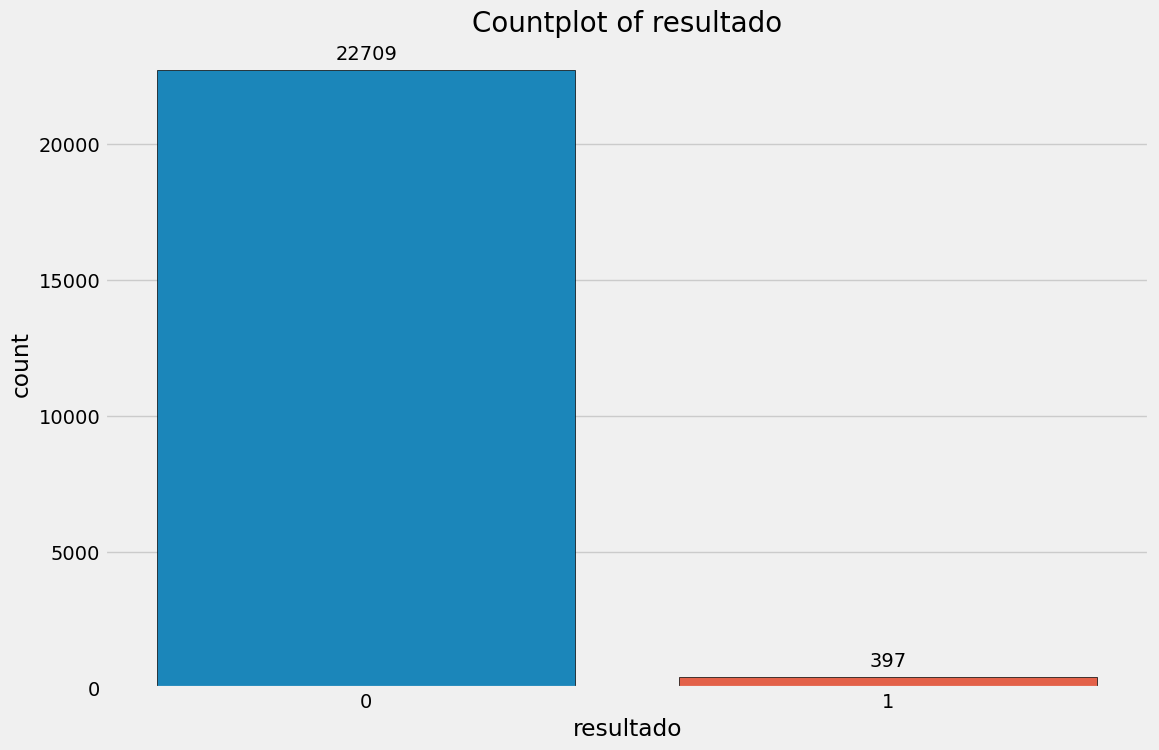

In [17]:
fast_eda(df_principal_components, target = "resultado")

## The dataset is very unbalanced!! We will solve this.... <a name="imbalanced_data"></a>

In [18]:
minority_class = 1
majority_class = 0
target_column = 'resultado'
df_final = undersample_dataframe(df_principal_components, majority_class, minority_class, target_column)

DataFrame Head:


PC1       PC2       PC3       PC4       PC5       PC6  resultado
0 -0.750320 -0.373452  0.338698 -0.573952  0.028038 -0.178813          1
1  1.531562  2.641141 -0.486014 -0.126440  0.020965 -0.166914          1
2  0.645407 -0.974496  0.779706  0.889449  0.086481  0.710003          0

DataFrame Tail:


PC1       PC2       PC3       PC4       PC5       PC6  resultado
791 -0.324263  0.187756 -0.295639  0.599790 -0.495333 -0.276510          0
792 -1.984819  1.892913  0.668137  0.700957  0.259931 -0.285768          1
793 -0.432084  0.288687  0.630254  0.177903 -0.564404 -0.293077          0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(794, 7)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PC1        794 non-null    float64
 1   PC2        794 non-null    float64
 2   PC3        794 non-null    float64
 3   PC4        794 non-null    float64
 4   PC5        794 non-null    float64
 5   PC6        794 non-null    float64
 6   resultado  794 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 43.6 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



----------------------------------------------------------------------------------------------------
DataFrame Correlation:



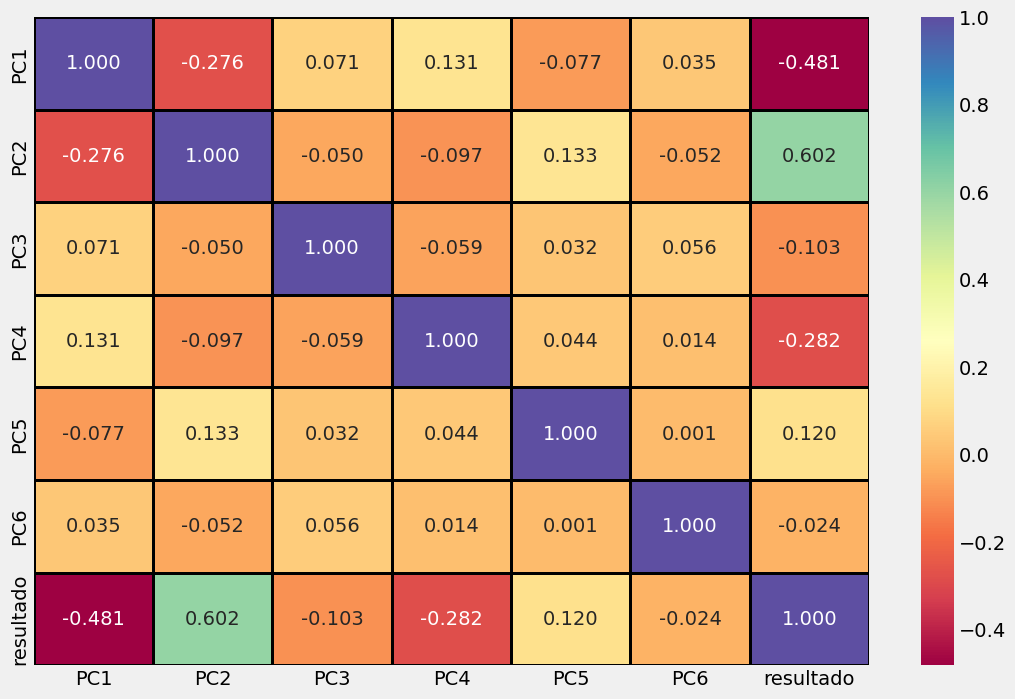

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



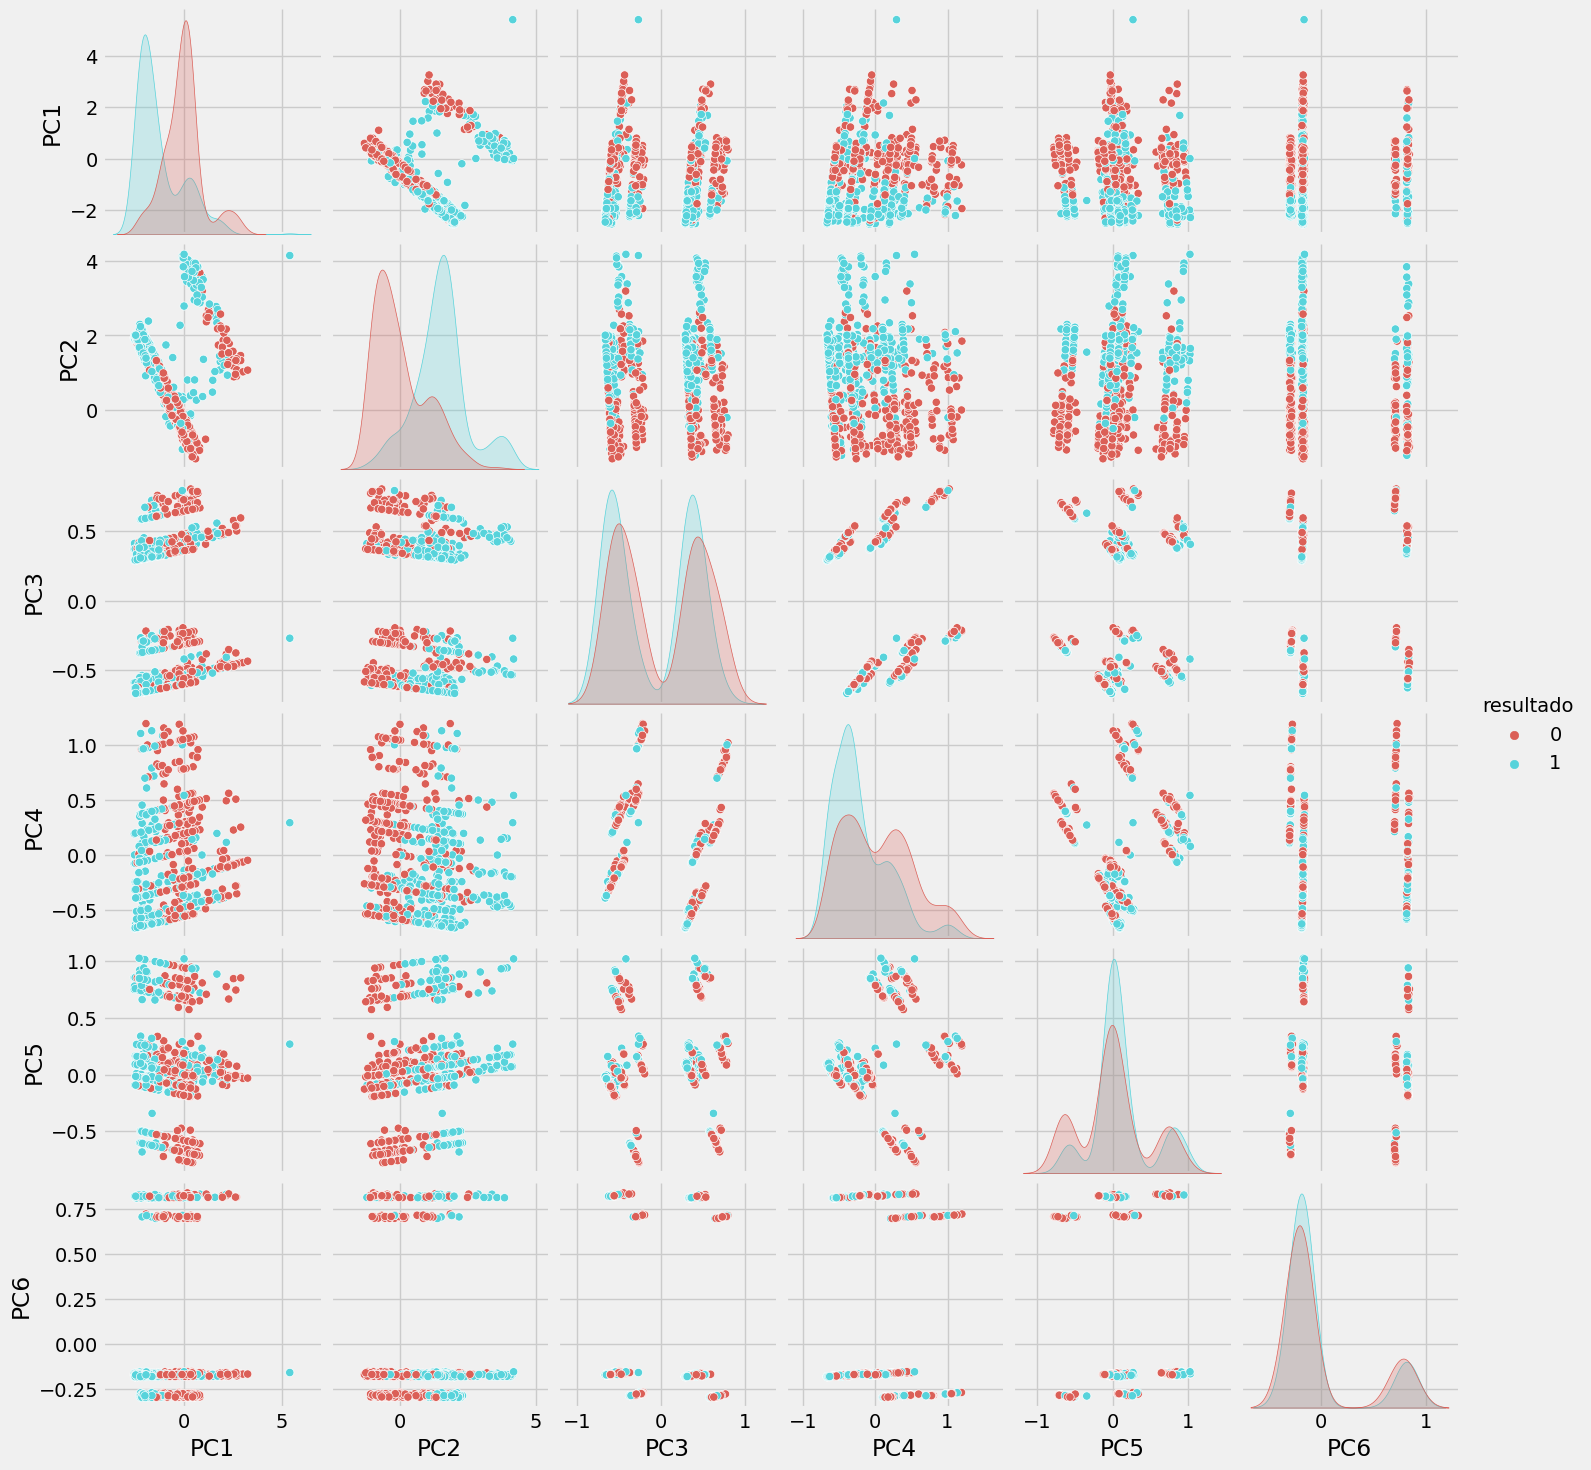

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



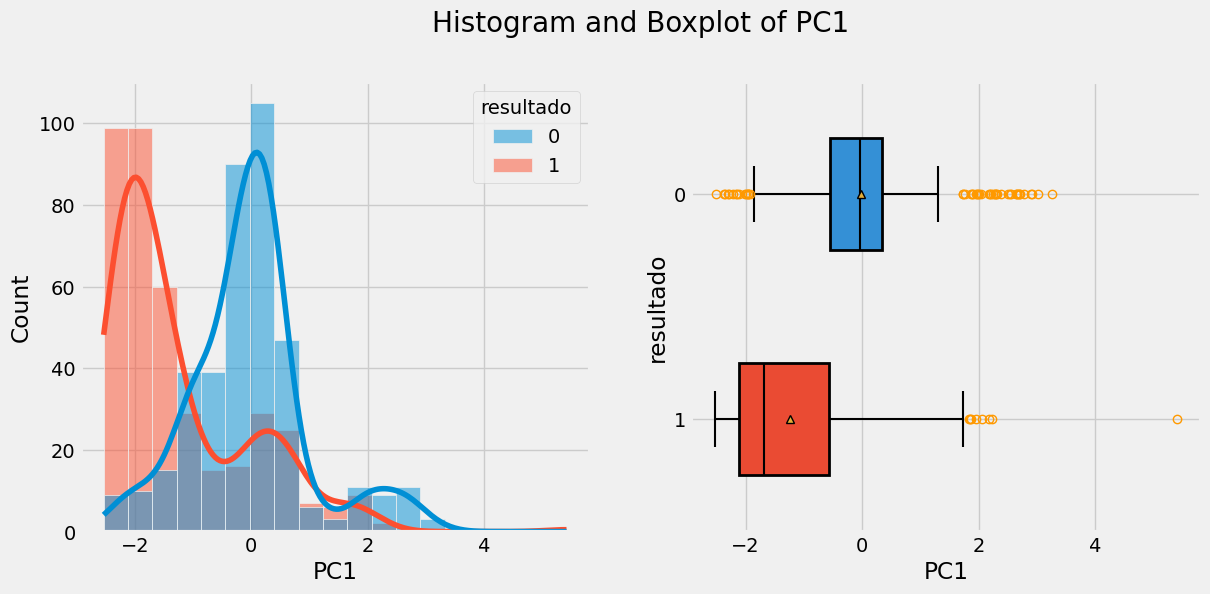

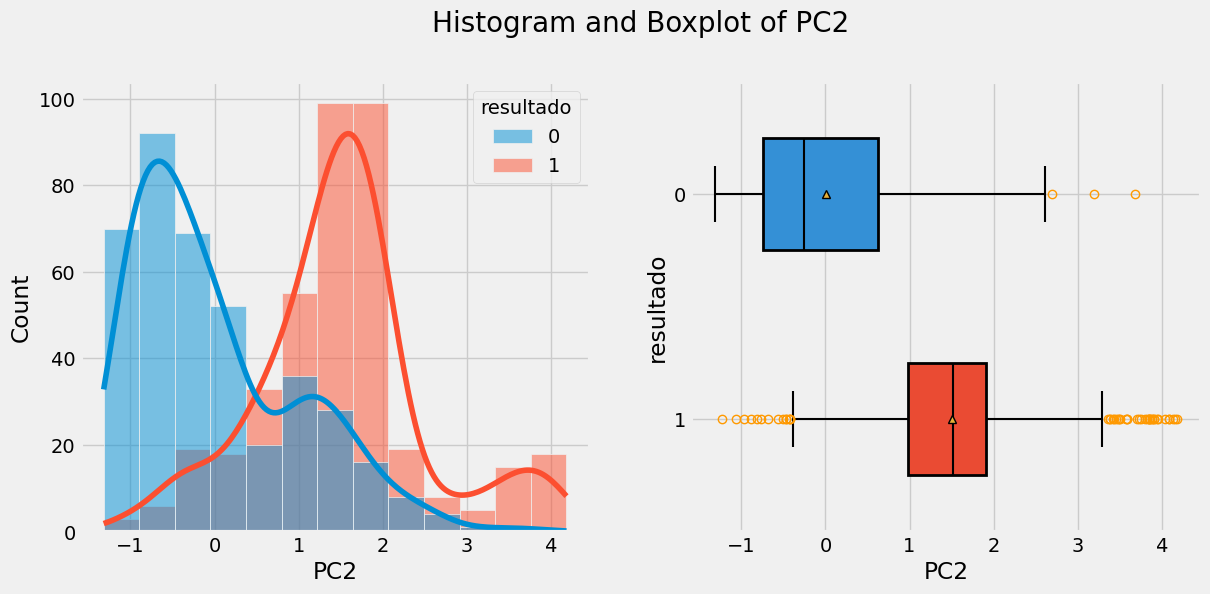

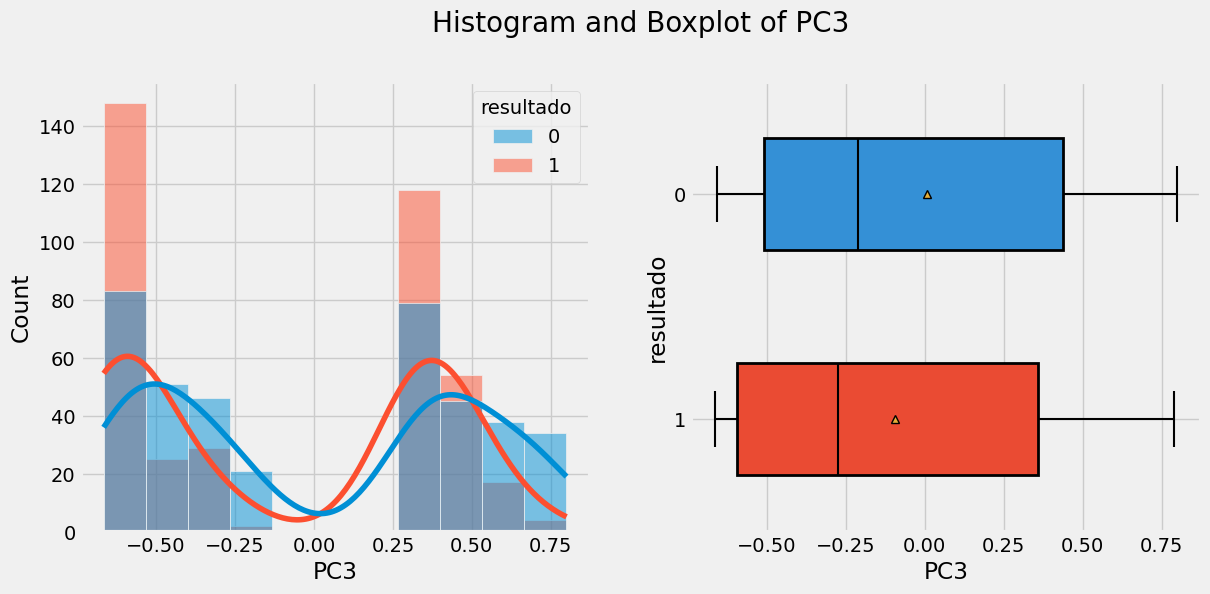

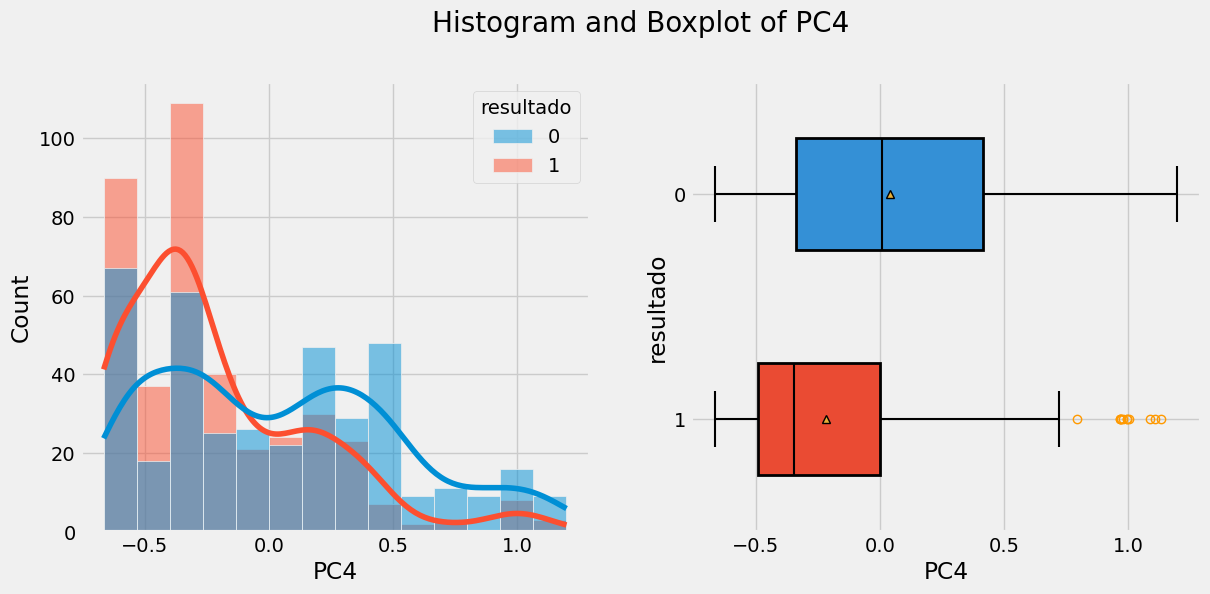

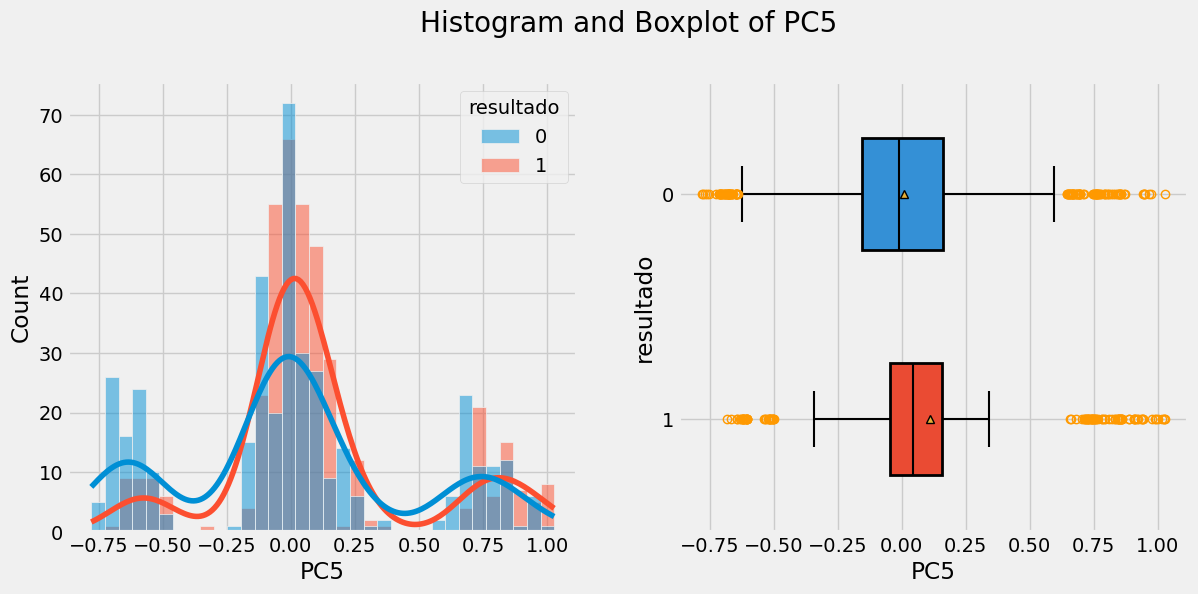

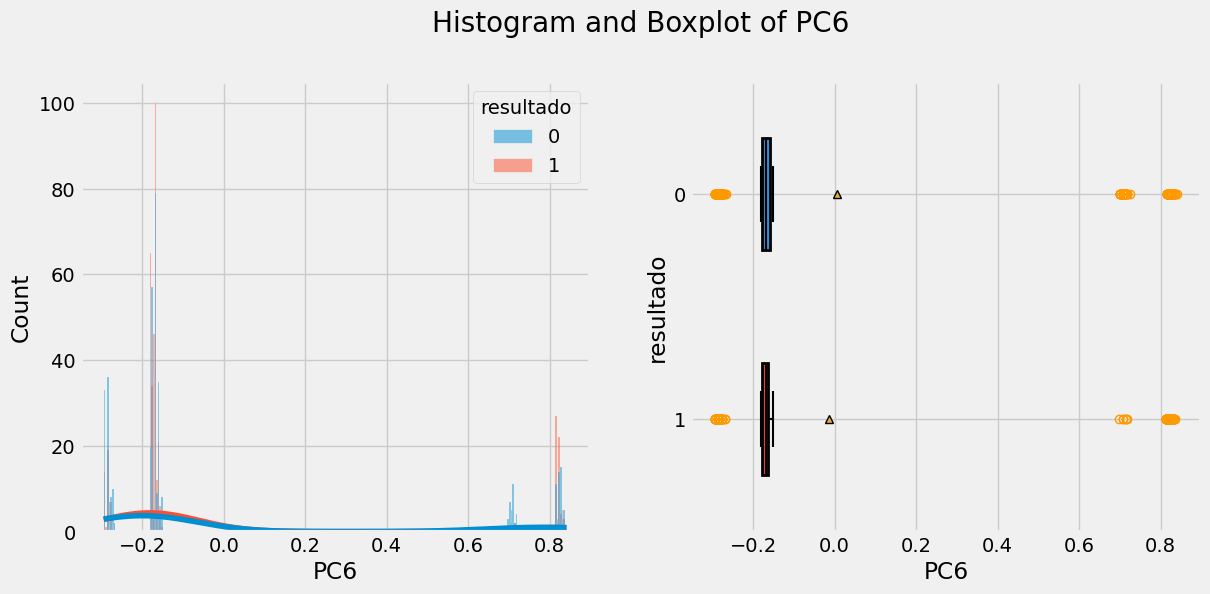

----------------------------------------------------------------------------------------------------
Countplot(s):



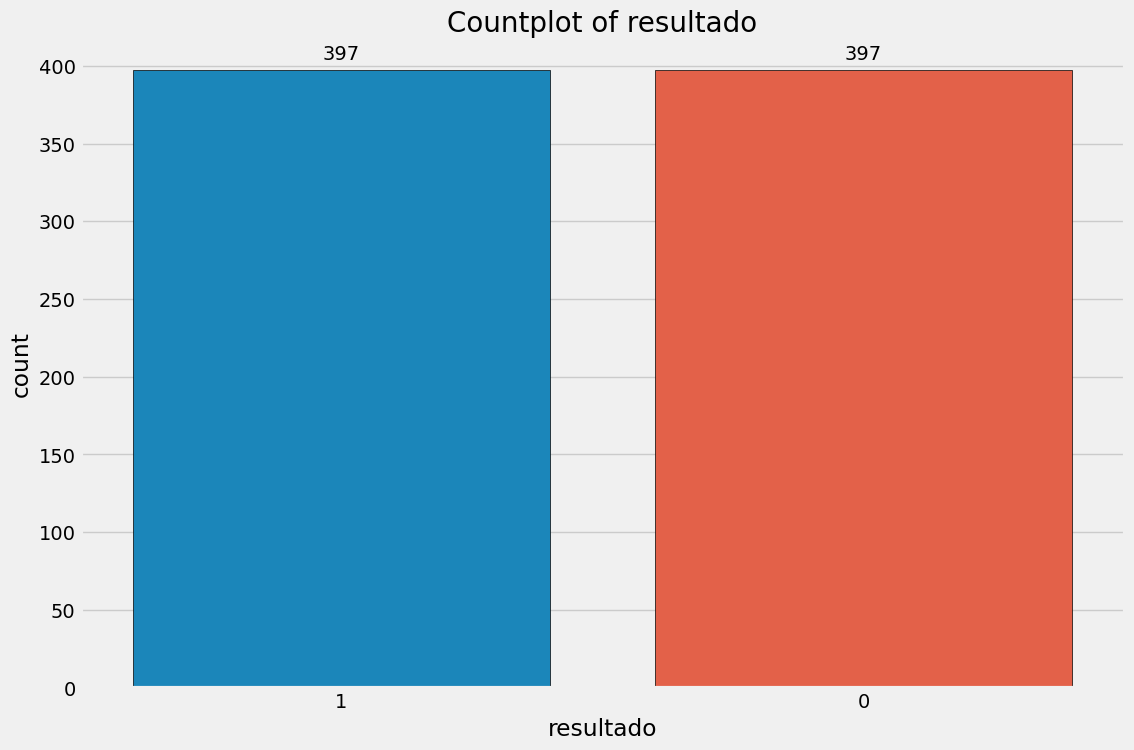

In [19]:
fast_eda(df_final, target = "resultado")

# Creating and evaluating classifiers performance <a name="creating_classifiers"></a>

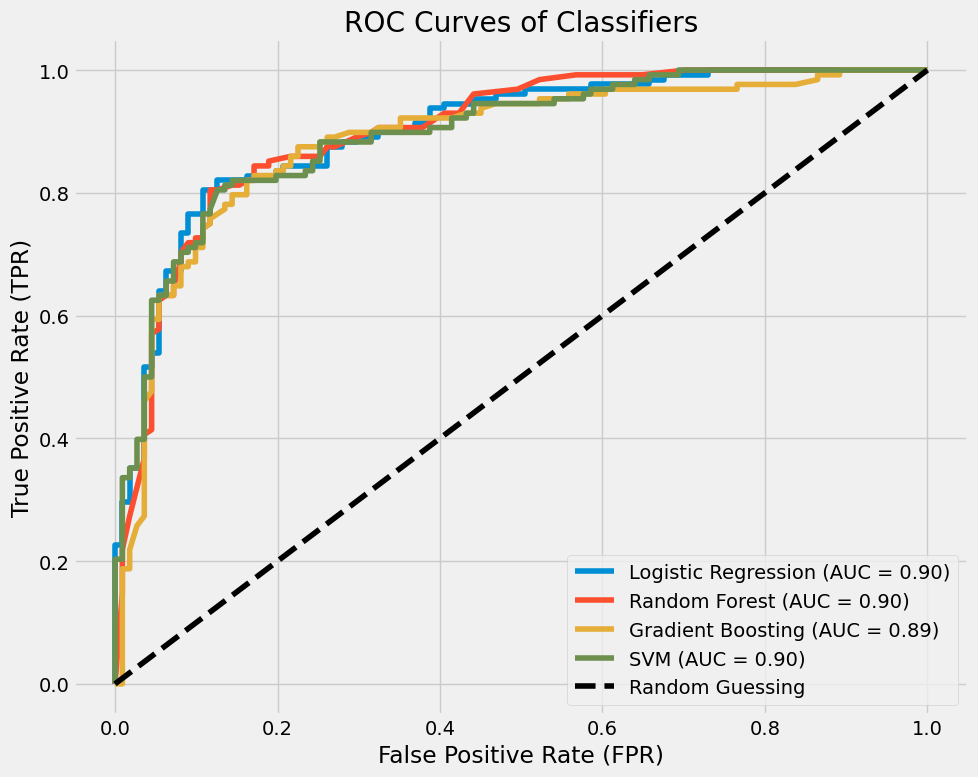

In [20]:
best_clf = compare_models(df_final)

## Transform an original single row and predict the result  <a name="predict_row"></a>

In [21]:
transformed_row = transform_single_row_with_dataframe(random_row_removed, df, pca, target_column='resultado')

In [22]:
transformed_row

PC1       PC2       PC3       PC4      PC5       PC6  resultado
41187 -1.201737  0.688873  0.021547  1.191905 -0.24052  0.001979          0

In [23]:
transformed_row_features = transformed_row.drop('resultado', axis=1).values.reshape(1, -1)
transformed_row_features

array([[-1.20173683,  0.68887316,  0.02154662,  1.19190472, -0.24051991,
         0.0019791 ]])

In [24]:
predicted_prob = best_clf.predict_proba(transformed_row_features)[0][1]

In [25]:
# the probability for the transformed_row to belong to class 1 is approximately 16.38% and 83.62% to percent to class 0.
predicted_prob

0.16386234675533237

In [26]:
predicted_class = best_clf.predict(transformed_row_features)[0]

In [27]:
#As expected, the predicted class is 0.
predicted_class

0